# EDA – Music Genre Classification 

Notebook này thực hiện phân tích dữ liệu khám phá (Exploratory Data Analysis – EDA) cho bài toán **Music Genre Classification** trên Kaggle.

Mục tiêu chính:

1. Hiểu rõ cấu trúc dữ liệu, kiểu dữ liệu, kích thước, chất lượng dữ liệu.
2. Phân tích phân phối của biến mục tiêu `Class` và các đặc trưng âm thanh:
   - `danceability`, `energy`, `loudness`, `speechiness`, `acousticness`, `instrumentalness`, `liveness`, `valence`, `tempo`, v.v.
3. Phân tích mối quan hệ giữa các biến với nhau và với `Class`:
   - Biểu đồ phân phối, boxplot, violin, correlation heatmap, kiểm định ANOVA / Kruskal.
4. Phân tích đa chiều:
   - PCA (giảm chiều) + KMeans clustering để xem cấu trúc không gian đặc trưng.
5. Chuẩn bị insight cụ thể để dùng cho:
   - Thiết kế **Feature Engineering** và **Processing** cho Exp1 (raw) và Exp2 (full FE).


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
pd.set_option("display.max_columns", None)

RANDOM_STATE = 42

train=pd.read_csv('../data/raw/train (1).csv')
test=pd.read_csv('../data/raw/test (2).csv')

print("Train shape:", train.shape)
print("Test shape :", test.shape)
train.head()

Train shape: (14396, 18)
Test shape : (3600, 17)


,Id,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,1,Marina Maximilian,Not Afraid,37.0,0.334,0.536,9.0,-6.649,0,0.0381,0.378000,NaN,0.106,0.235,152.429,204947.0,4,9
1,2,The Black Keys,Howlin' for You,67.0,0.725,0.747,11.0,-5.545,1,0.0876,0.027200,0.0468,0.104,0.380,132.921,191956.0,4,6
2,3,Royal & the Serpent,phuck u,NaN,0.584,0.804,7.0,-6.094,1,0.0619,0.000968,0.6350,0.284,0.635,159.953,161037.0,4,10
3,4,Detroit Blues Band,Missing You,12.0,0.515,0.308,NaN,-14.711,1,0.0312,0.907000,0.0213,0.300,0.501,172.472,298093.0,3,2
4,5,Coast Contra,My Lady,48.0,0.565,0.777,6.0,-5.096,0,0.2490,0.183000,NaN,0.211,0.619,88.311,254145.0,4,5


## 1. Tổng quan cấu trúc dữ liệu

Trong phần này, chúng ta:

- Xem **kiểu dữ liệu** của từng cột (`info()`).
- Xem nhanh **thống kê mô tả** cho các biến số (`describe()`).
- Từ đó nhận diện:
  - Cột nào numeric, cột nào categorical/text.
  - Biến nào có giá trị cực trị, range rộng, có thể cần chuẩn hoá/biến đổi (log, standardize) trong bước processing.



In [3]:
print("=== INFO TRAIN ===")
train.info()
print("\n=== INFO TEST ===")
test.info()

display(train.describe().T)


=== INFO TRAIN ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14396 entries, 0 to 14395
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  14396 non-null  int64  
 1   Artist Name         14396 non-null  object 
 2   Track Name          14396 non-null  object 
 3   Popularity          14063 non-null  float64
 4   danceability        14396 non-null  float64
 5   energy              14396 non-null  float64
 6   key                 12787 non-null  float64
 7   loudness            14396 non-null  float64
 8   mode                14396 non-null  int64  
 9   speechiness         14396 non-null  float64
 10  acousticness        14396 non-null  float64
 11  instrumentalness    10855 non-null  float64
 12  liveness            14396 non-null  float64
 13  valence             14396 non-null  float64
 14  tempo               14396 non-null  float64
 15  duration_in min/ms  14396 non-null

,count,mean,std,min,25%,50%,75%,max
Id,14396.0,7198.500000,4155.911573,1.000000,3599.750000,7198.50000,10797.25000,14396.000
Popularity,14063.0,44.525208,17.418940,1.000000,33.000000,44.00000,56.00000,100.000
danceability,14396.0,0.543105,0.165517,0.059600,0.432000,0.54500,0.65800,0.989
energy,14396.0,0.662422,0.235967,0.001210,0.508000,0.69900,0.86100,1.000
key,12787.0,5.953781,3.200013,1.000000,3.000000,6.00000,9.00000,11.000
loudness,14396.0,-7.900852,4.057362,-39.952000,-9.538000,-7.01350,-5.16200,1.342
mode,14396.0,0.640247,0.479944,0.000000,0.000000,1.00000,1.00000,1.000
speechiness,14396.0,0.080181,0.085157,0.022500,0.034800,0.04710,0.08310,0.955
acousticness,14396.0,0.246746,0.310922,0.000000,0.004280,0.08145,0.43225,0.996
instrumentalness,10855.0,0.178129,0.304266,0.000001,0.000088,0.00392,0.20100,0.996


## 2. Phân tích Missing Values

Bước này rất quan trọng cho processing:

- Xác định các cột có giá trị thiếu (missing).
- Tỷ lệ thiếu (%) trên toàn bộ tập dữ liệu.
- Hình dung pattern missing (random hay tập trung ở một số dòng/cột).

Thông tin này sẽ quyết định:
- Ta **impute** như thế nào (mean/median/mode/advanced).
- Cột nào có thể cần bỏ nếu thiếu quá nhiều.


Missing in train:
Missing in test:


,Missing,%
instrumentalness,3541,24.597110
key,1609,11.176716
Popularity,333,2.313143


,Missing,%
instrumentalness,836,23.222222
key,405,11.250000
Popularity,95,2.638889


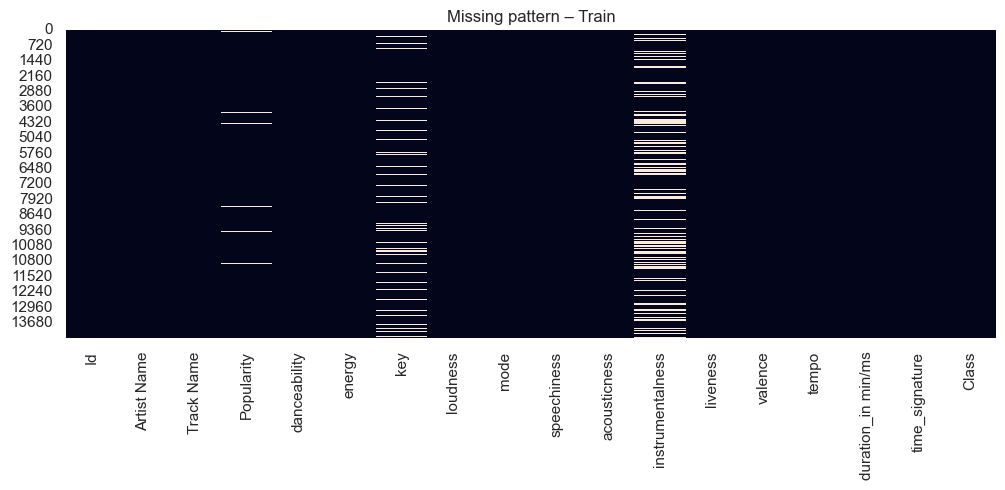

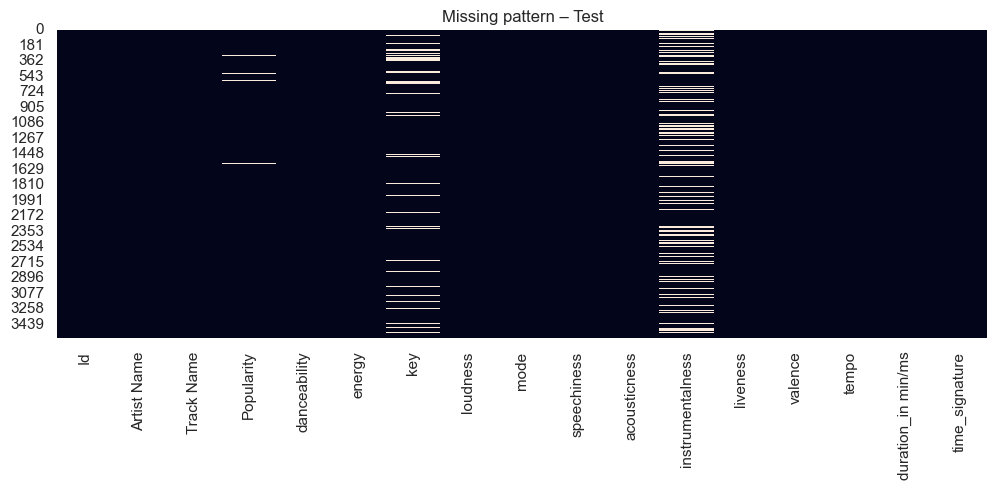

In [4]:
def missing_table(df, name="df"):
    mis = df.isnull().sum()
    mis_pct = mis / len(df) * 100
    tab = pd.concat([mis, mis_pct], axis=1)
    tab.columns = ["Missing", "%"]
    tab = tab[tab["Missing"] > 0].sort_values("%", ascending=False)
    print(f"Missing in {name}:")
    return tab

missing_train = missing_table(train, "train")
missing_test  = missing_table(test, "test")

display(missing_train)
display(missing_test)

plt.figure(figsize=(12, 4))
sns.heatmap(train.isnull(), cbar=False)
plt.title("Missing pattern – Train")
plt.show()

plt.figure(figsize=(12, 4))
sns.heatmap(test.isnull(), cbar=False)
plt.title("Missing pattern – Test")
plt.show()


**Nhận xét:**

- `instrumentalness` có tỷ lệ thiếu khá cao → cần chiến lược impute rõ ràng (vd: median).
- `key`, `Popularity` thiếu ít hơn nhưng vẫn cần xử lý.
- Các cột khác hầu như đầy đủ.

Thông tin này sẽ được dùng trực tiếp trong notebook **processing** để thiết kế hàm `impute_missing()`.


## 3. Biến mục tiêu `Class` – phân phối & mất cân bằng

Ở bước này, ta:

- Đếm số mẫu mỗi lớp `Class`.
- Tính tỷ lệ (%) từng lớp.
- Tính **imbalance ratio** (max/min) để xem bài toán có mất cân bằng mạnh không.

Điều này ảnh hưởng đến:
- Cách chia train/validation (nên dùng Stratified).
- Có cần xử lý imbalance (class weights, oversampling, focal loss, ...) trong modeling hay không.


,Class,Count,Percent
0,0,500,3.47
1,1,1098,7.63
2,2,1018,7.07
3,3,322,2.24
4,4,310,2.15
5,5,1157,8.04
6,6,2069,14.37
7,7,461,3.20
8,8,1483,10.30
9,9,2019,14.02


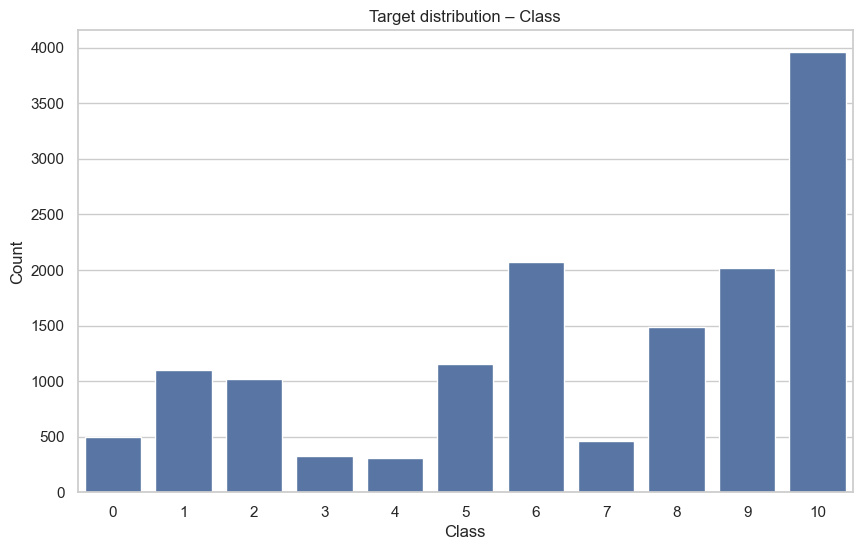

Imbalance ratio (max/min): 12.77


In [5]:
# Phân phối Class
class_counts = train["Class"].value_counts().sort_index()
class_pct = class_counts / len(train) * 100

display(pd.DataFrame({
    "Class": class_counts.index,
    "Count": class_counts.values,
    "Percent": class_pct.round(2).values
}))

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Target distribution – Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Imbalance ratio (max/min)
imbalance_ratio = class_counts.max() / class_counts.min()
print("Imbalance ratio (max/min):", round(imbalance_ratio, 2))




## 4. So sánh Train vs Test cho một số feature chính

Mục tiêu:

- Kiểm tra xem phân phối các feature quan trọng giữa `train` và `test` có khác nhau nhiều không.
- Nếu có **dataset shift** mạnh → có thể ảnh hưởng tới khả năng generalize của model.

Ở đây ta chọn một vài biến tiêu biểu: `Popularity`, `danceability`, `energy`, `acousticness`, `tempo`.


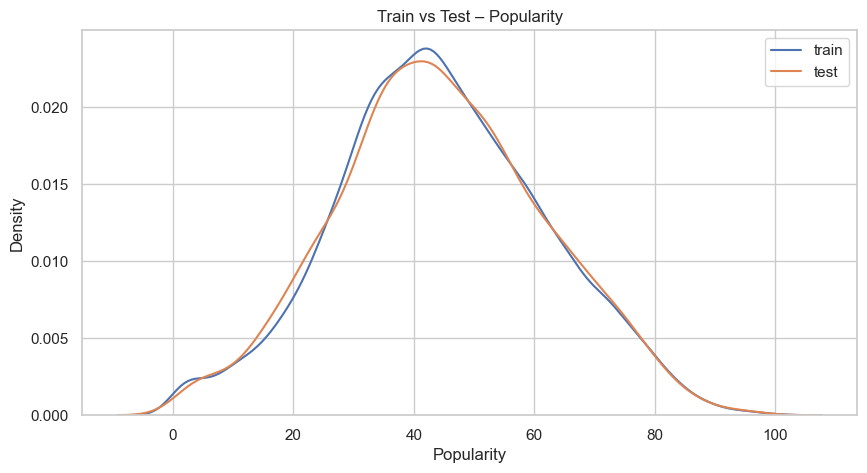

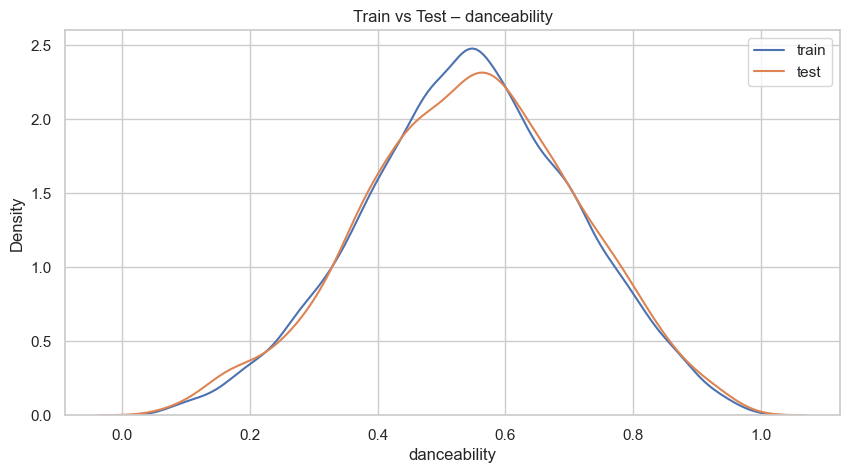

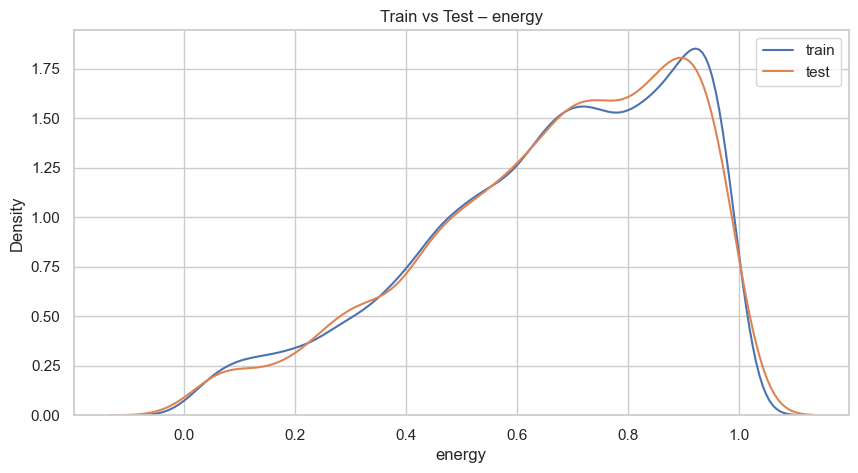

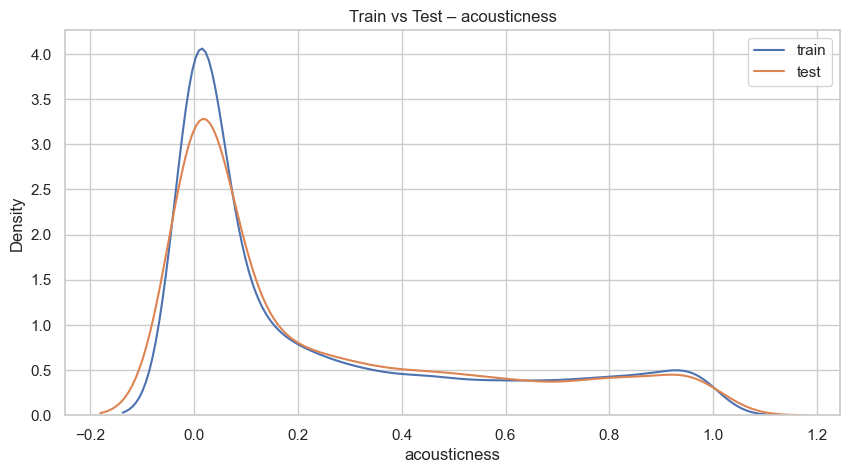

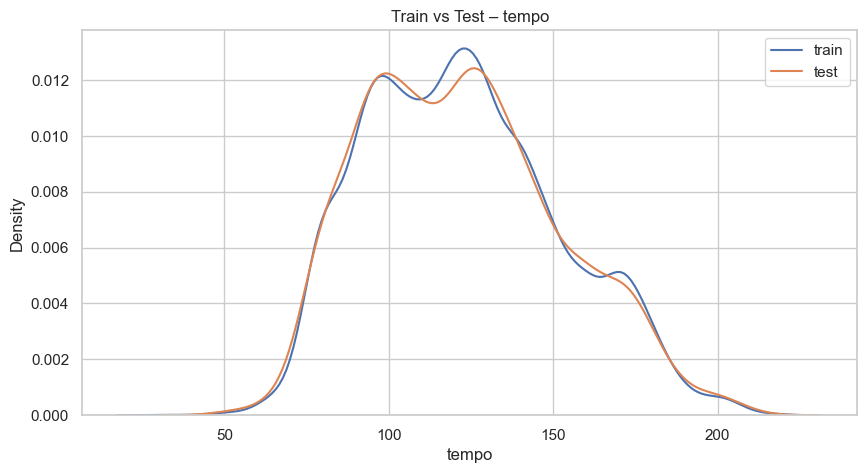

In [6]:
# So sánh phân phối một số feature chính giữa train & test (drift check)
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ["Id", "Class"]]

for col in ["Popularity", "danceability", "energy", "acousticness", "tempo"]:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(train[col].dropna(), label="train")
    sns.kdeplot(test[col].dropna(), label="test")
    plt.title(f"Train vs Test – {col}")
    plt.legend()
    plt.show()

## 5. Phân tích đơn biến (Univariate Analysis) cho các feature numeric

Ở bước này ta xem:

- Thống kê mô tả mở rộng: thêm **skewness** và **kurtosis**.
- Biểu đồ phân phối (hist + KDE) cho từng feature numeric.
- Từ đó nhận diện:
  - Biến nào bị lệch mạnh (skewed) → ứng viên cho log-transform.
  - Biến nào có nhiều outlier → cần xem xét winsorize/clipping.

Điều này giúp định hướng bước Feature Engineering & scaling.


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
time_signature,14396.0,3.924354,0.359520,1.000000,4.000000,4.00000,4.00000,5.000,-4.109400,27.411911
speechiness,14396.0,0.080181,0.085157,0.022500,0.034800,0.04710,0.08310,0.955,3.113395,12.870291
liveness,14396.0,0.195782,0.159258,0.011900,0.097275,0.12900,0.25600,0.992,2.178265,5.644791
loudness,14396.0,-7.900852,4.057362,-39.952000,-9.538000,-7.01350,-5.16200,1.342,-1.748073,4.979744
instrumentalness,10855.0,0.178129,0.304266,0.000001,0.000088,0.00392,0.20100,0.996,1.525166,0.702188
acousticness,14396.0,0.246746,0.310922,0.000000,0.004280,0.08145,0.43225,0.996,1.108933,-0.179024
duration_in min/ms,14396.0,200094.222824,111689.098211,0.501650,165445.750000,208941.00000,252247.00000,1477187.000,0.836407,8.697343
energy,14396.0,0.662422,0.235967,0.001210,0.508000,0.69900,0.86100,1.000,-0.656698,-0.328640
mode,14396.0,0.640247,0.479944,0.000000,0.000000,1.00000,1.00000,1.000,-0.584513,-1.658576
tempo,14396.0,122.695372,29.538490,30.557000,99.799000,120.06000,141.98825,217.416,0.376507,-0.445883


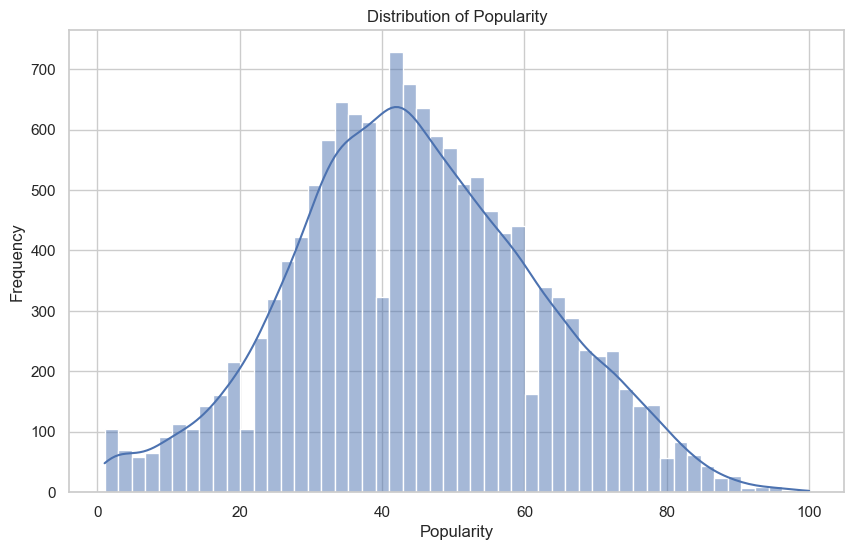

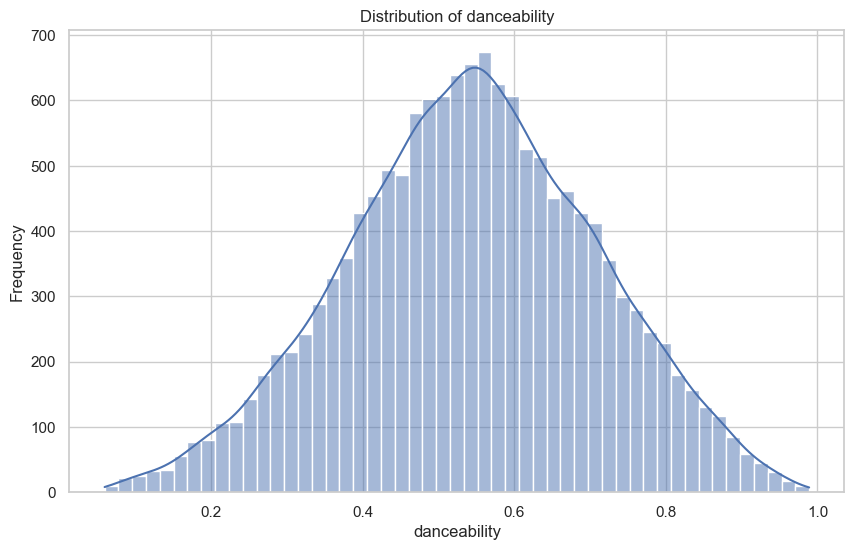

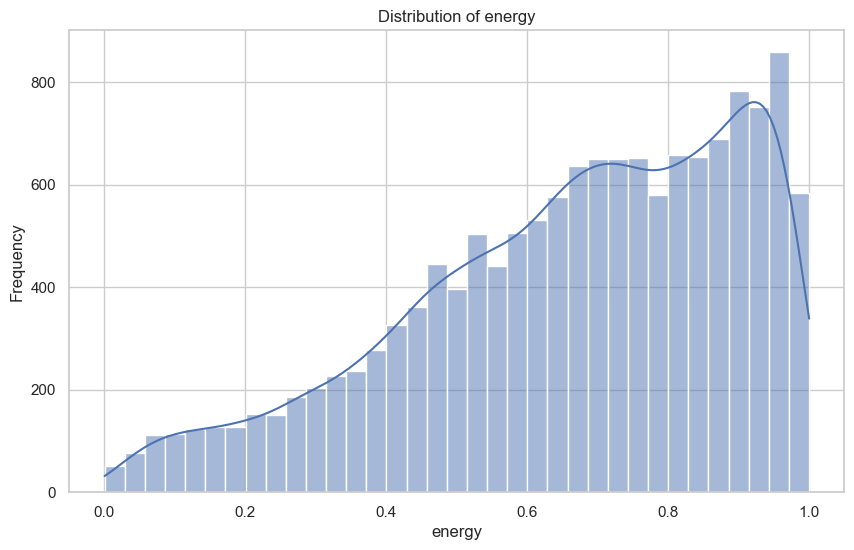

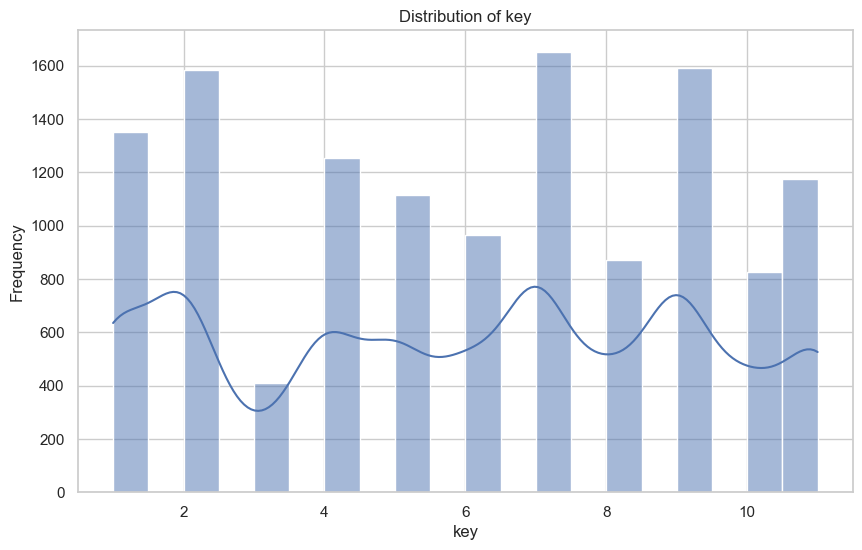

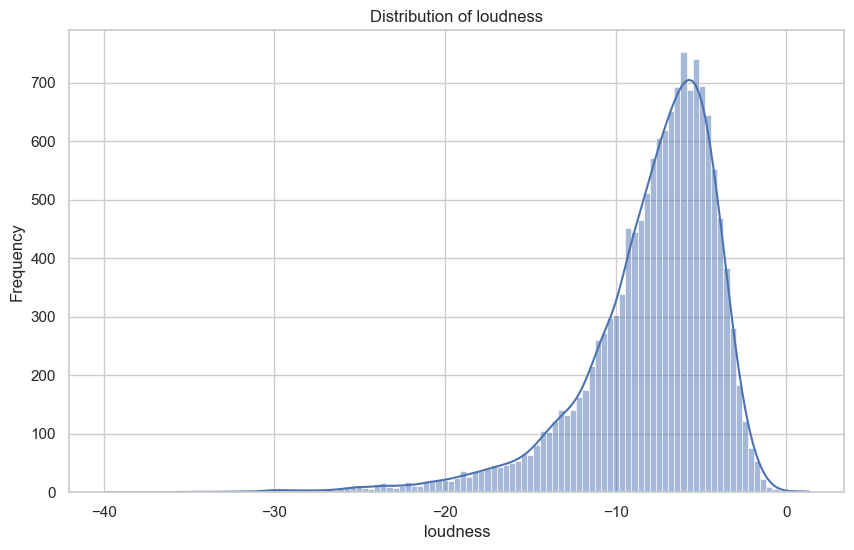

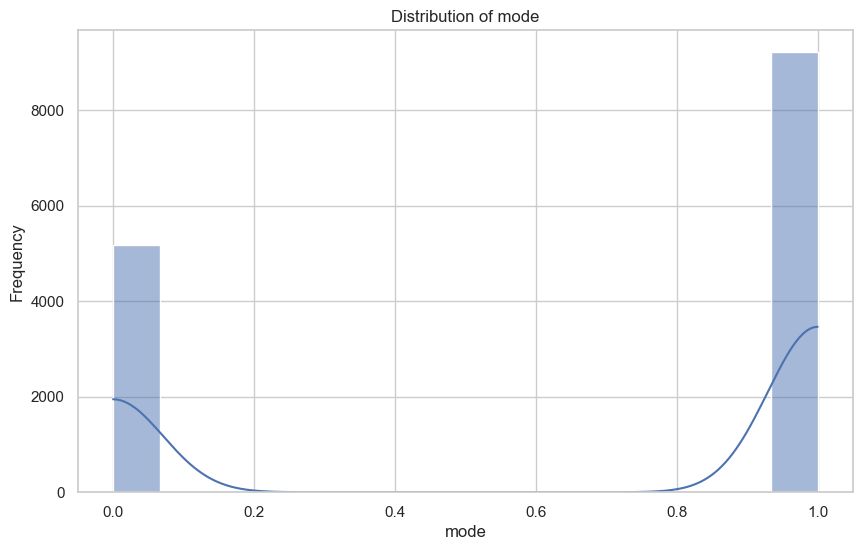

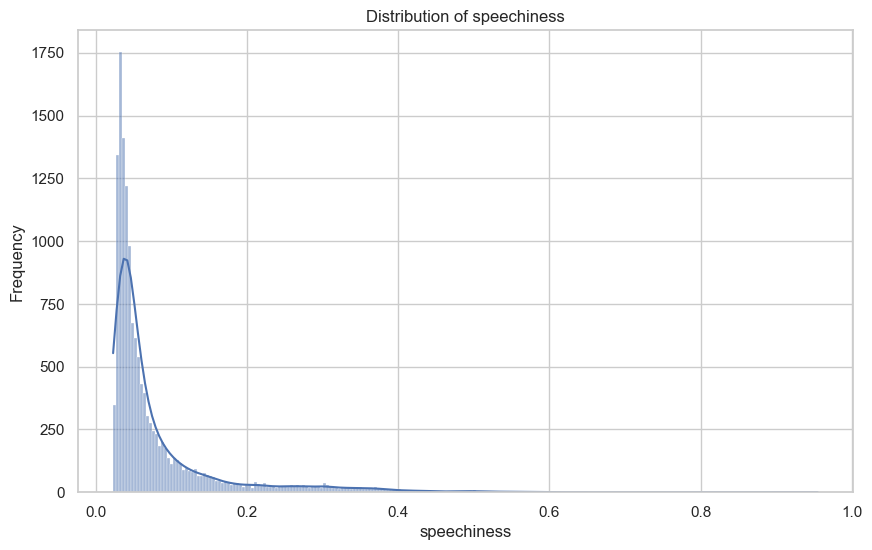

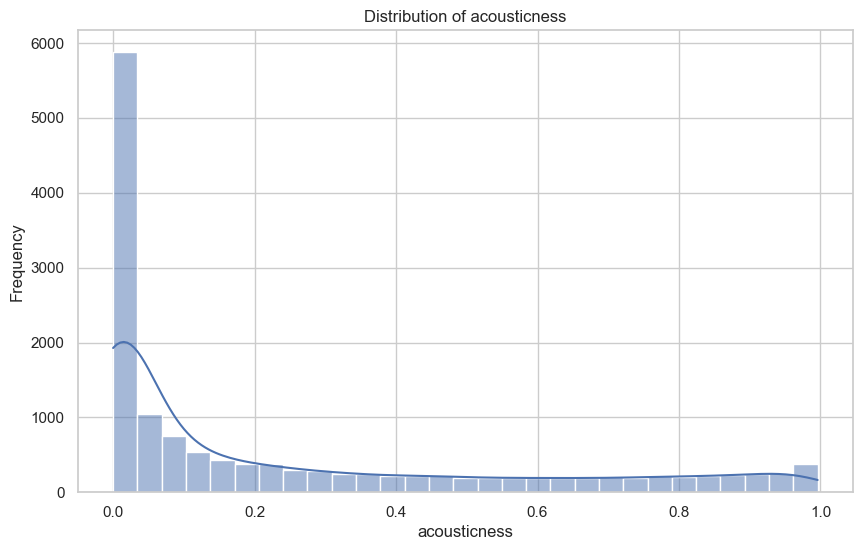

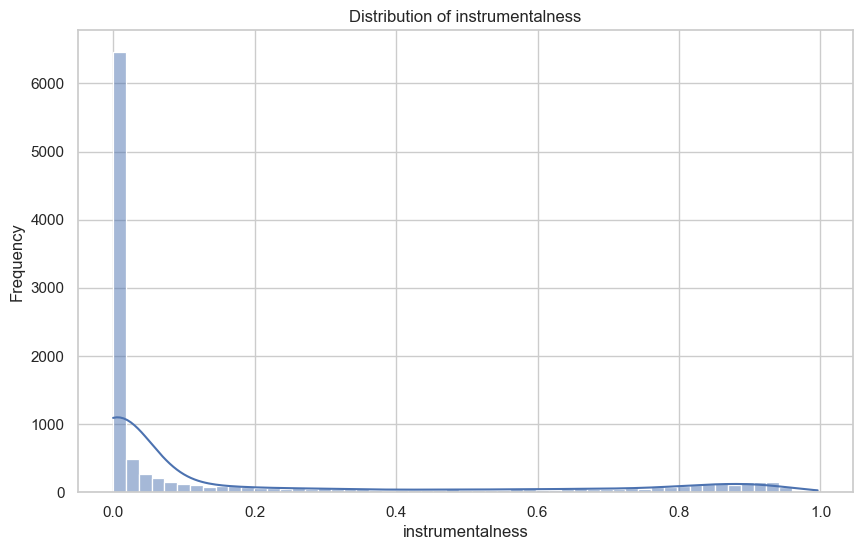

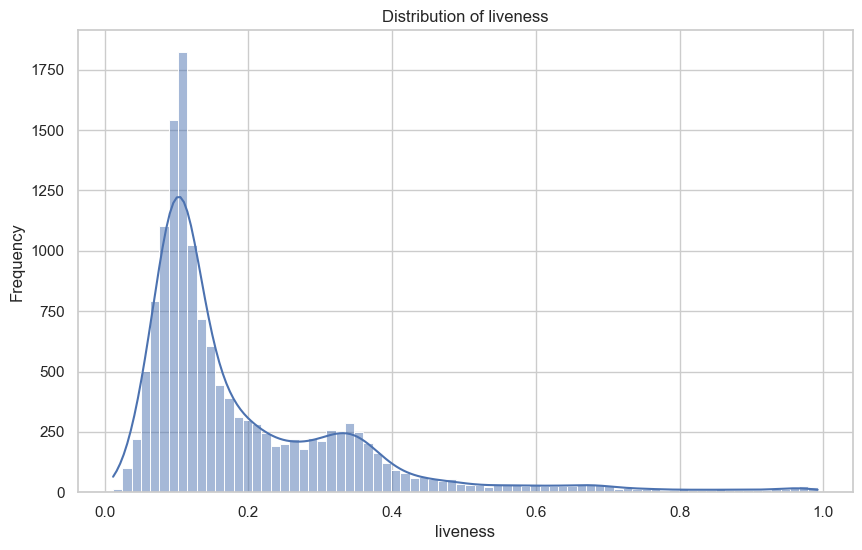

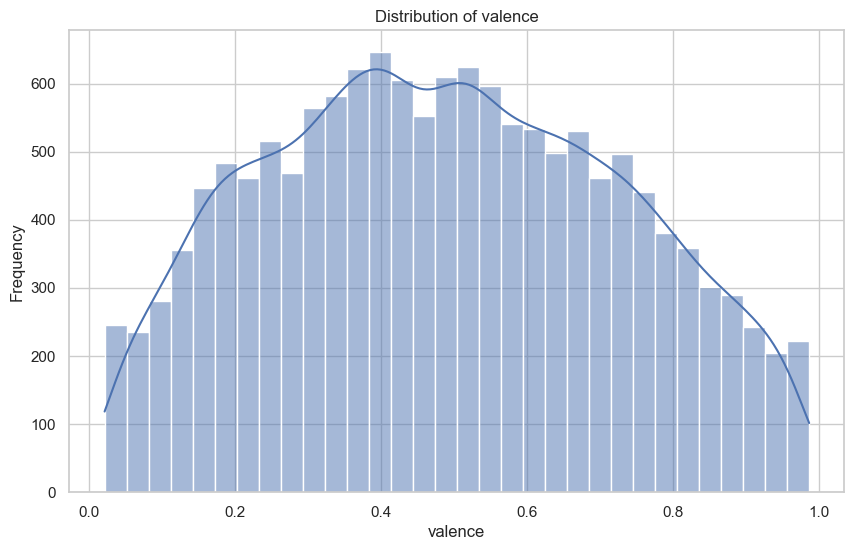

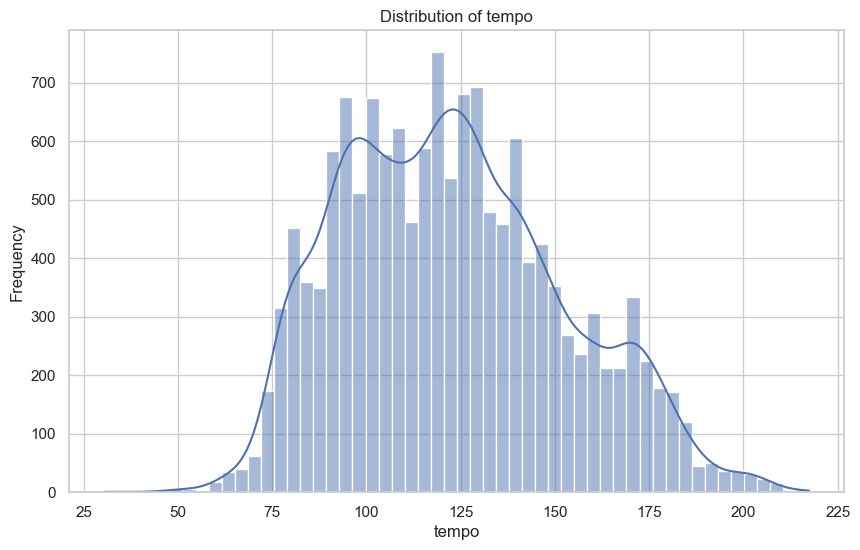

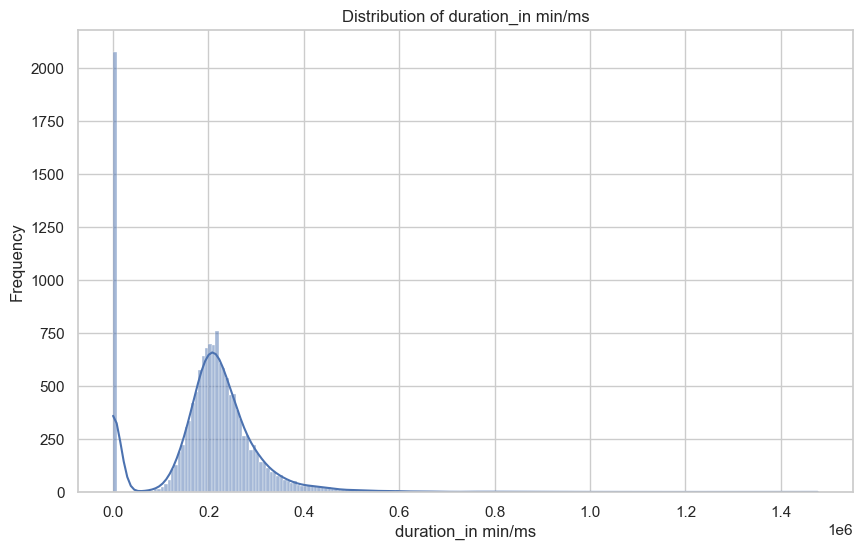

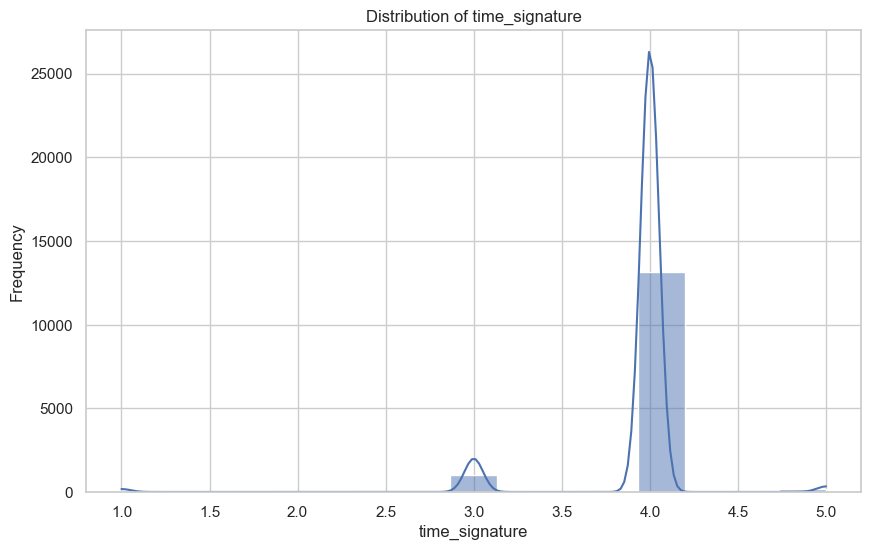

In [7]:
# Bảng thống kê chi tiết
desc = train[numeric_cols].describe().T
desc["skew"] = train[numeric_cols].skew()
desc["kurtosis"] = train[numeric_cols].kurtosis()
display(desc.sort_values("skew", key=abs, ascending=False))

# Plot hist + kde cho từng feature numeric
for col in numeric_cols:
    plt.figure()
    sns.histplot(train[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


## 6. Quan hệ giữa từng feature numeric và `Class`

Để xem biến nào **phân biệt các lớp tốt**, ta dùng:

- **Boxplot**: so sánh median, IQR của feature theo từng `Class`.
- **Violin plot**: xem dạng phân phối chi tiết hơn (nhiều mode, tail…).

Từ đó, ta có thể:
- Nhìn thấy lớp nào có `energy` cao hơn/ thấp hơn.
- Lớp nào có `acousticness` vượt trội.
- Gợi ý những feature giàu thông tin cho việc phân loại.


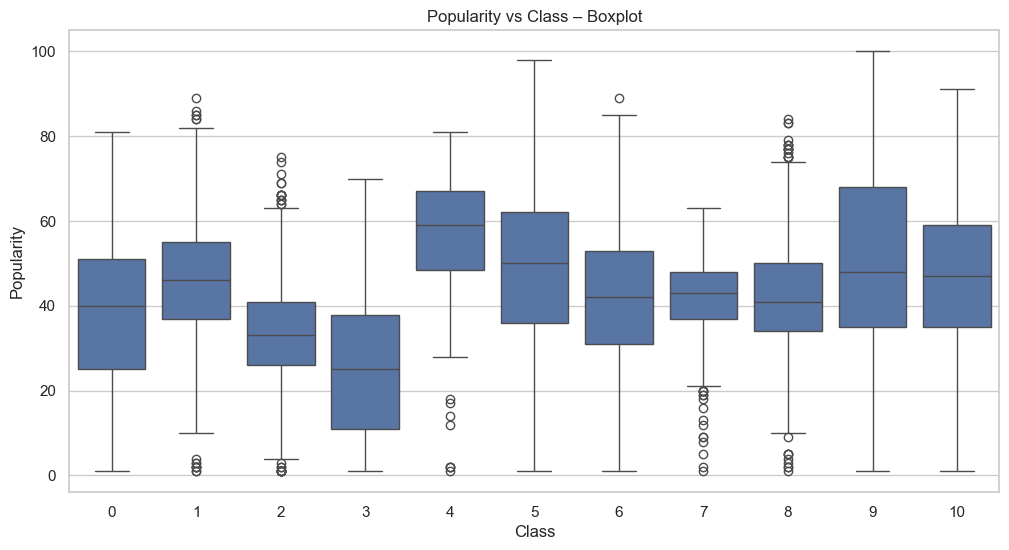

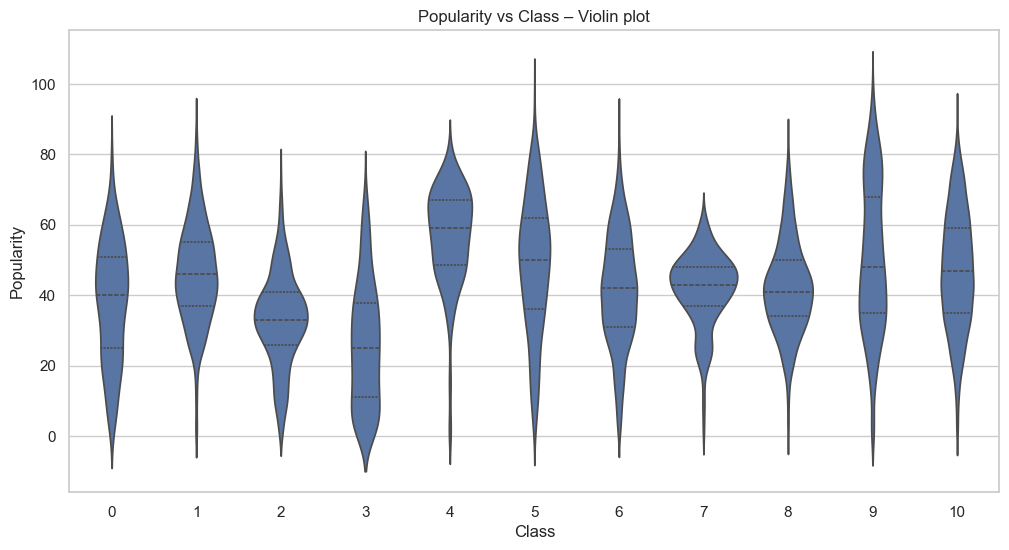

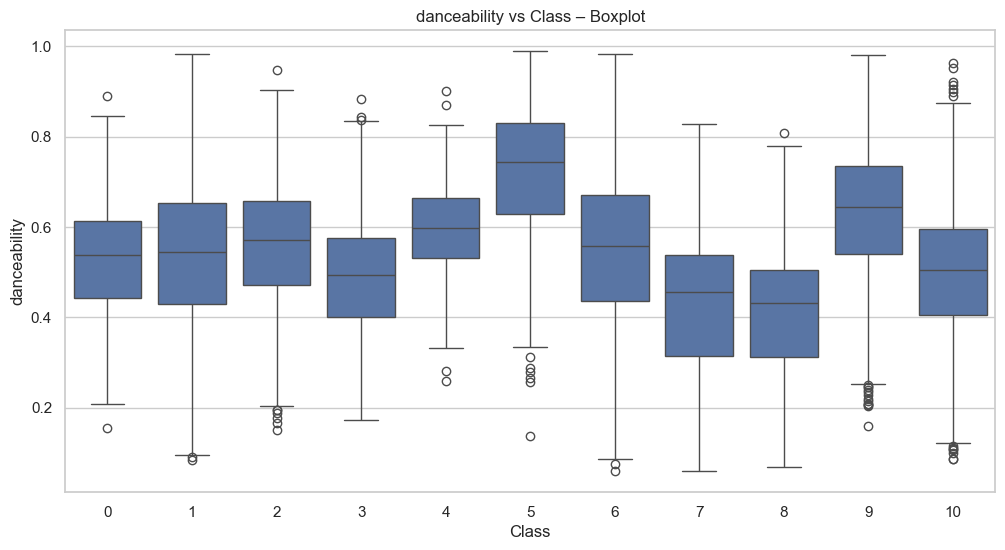

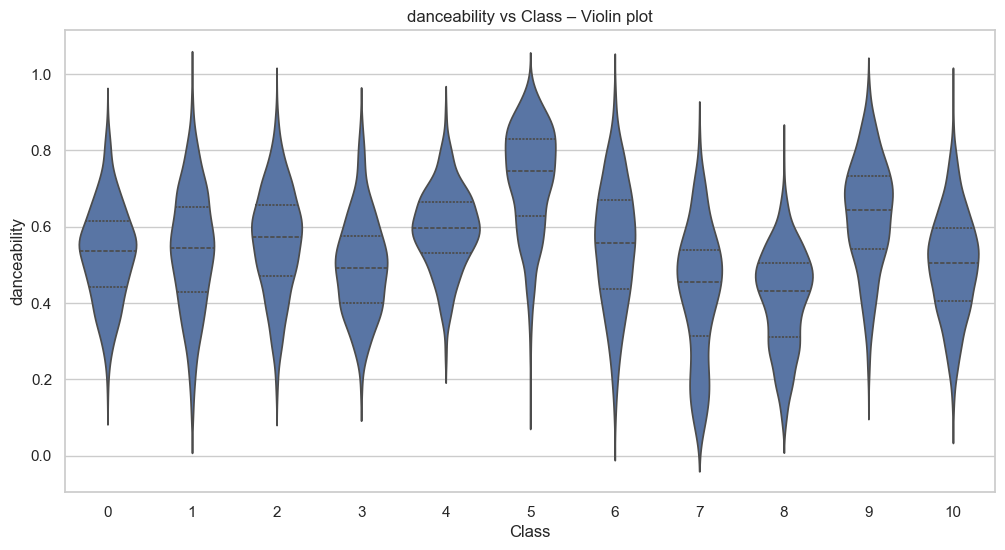

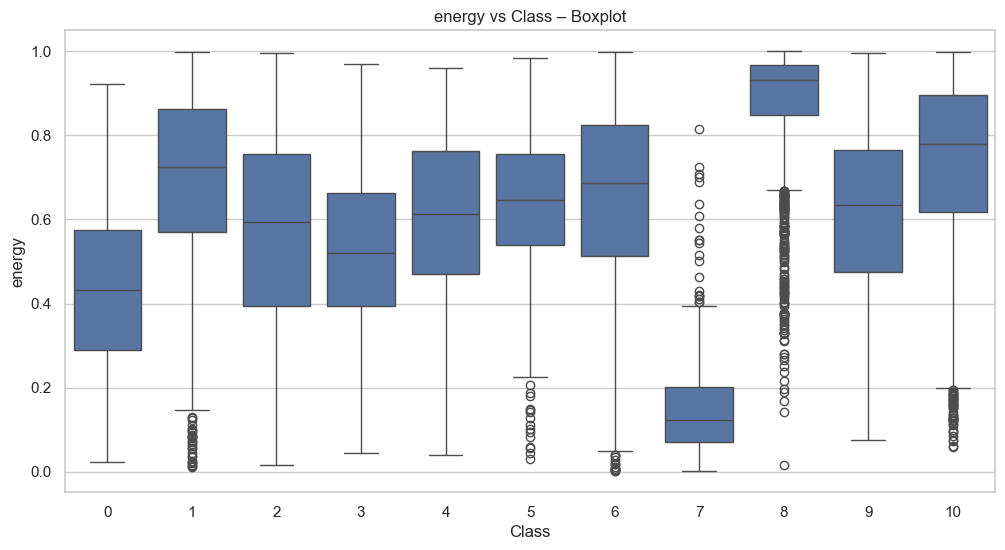

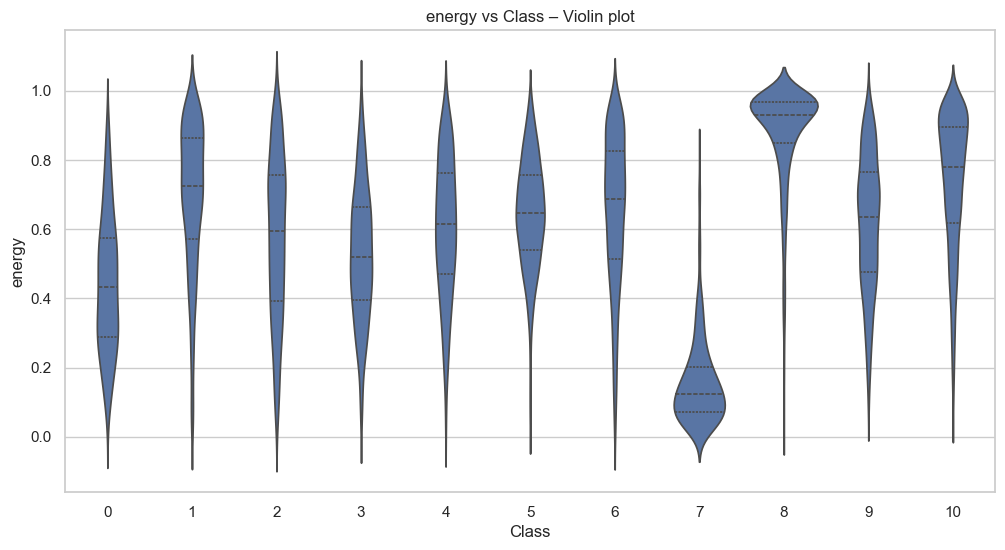

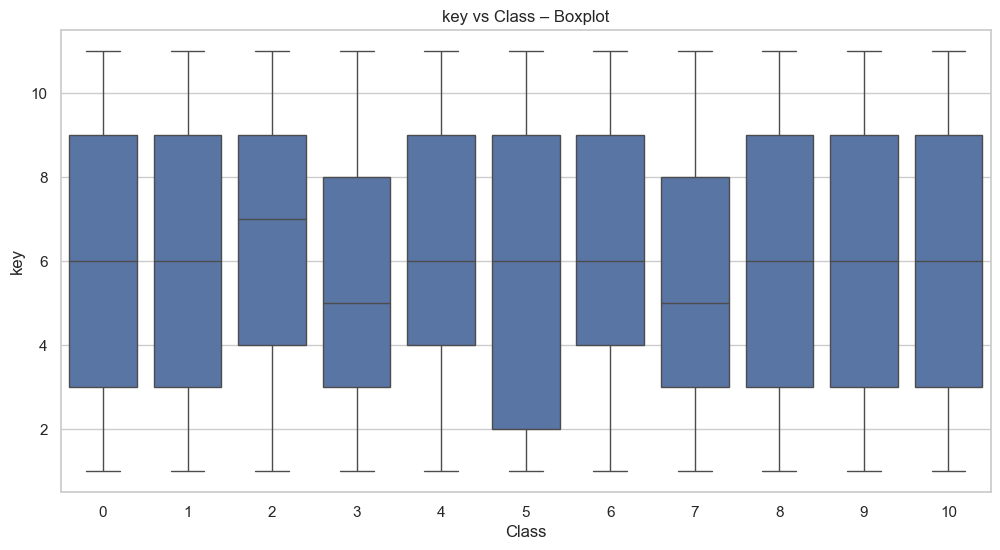

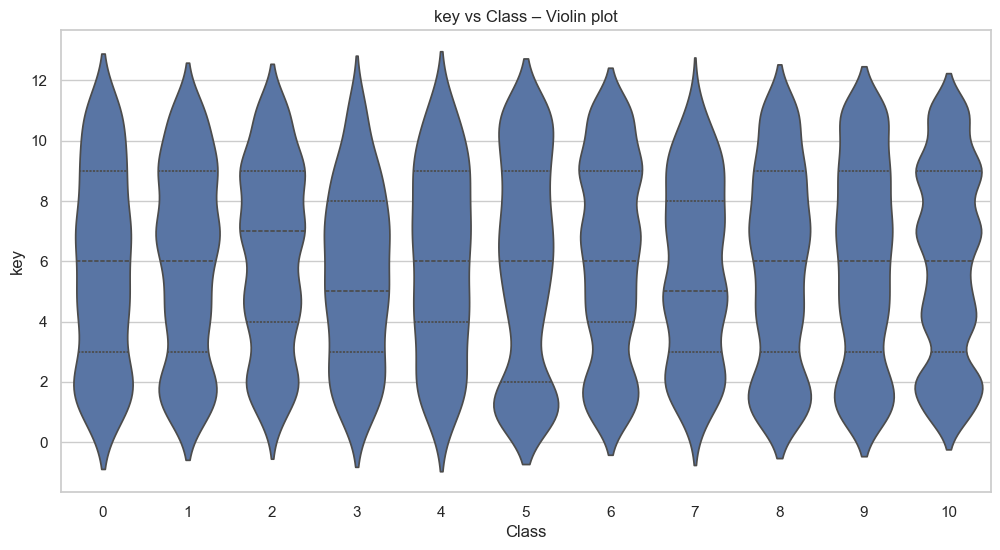

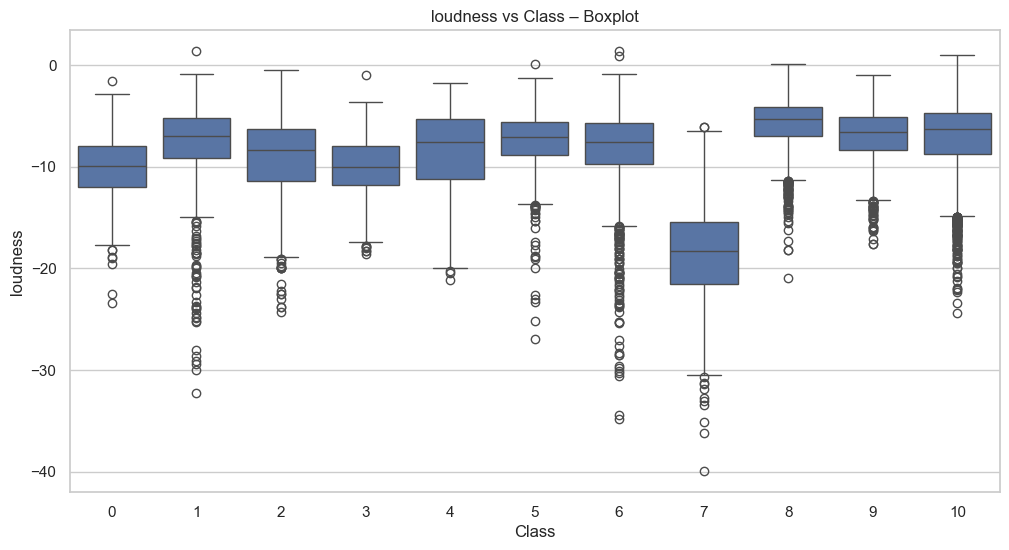

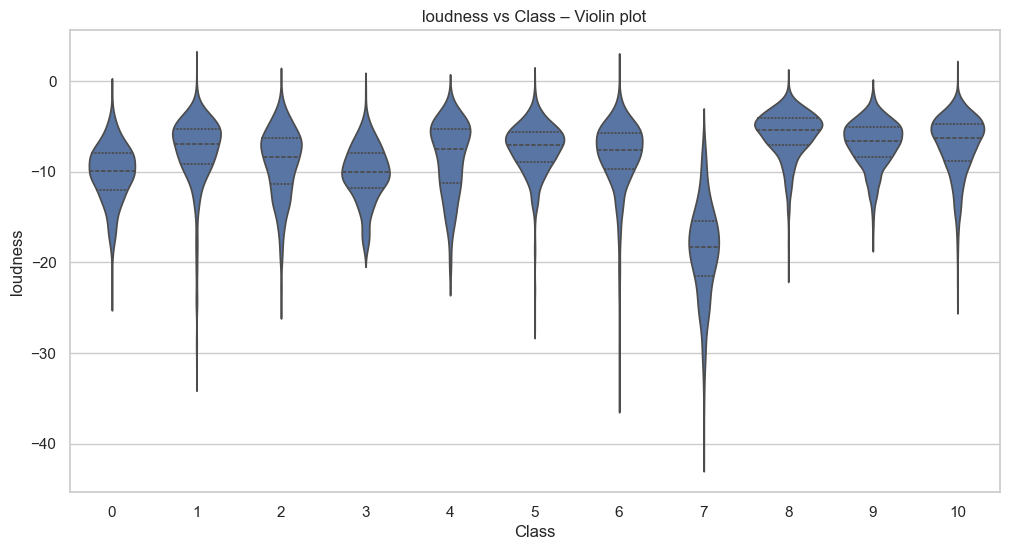

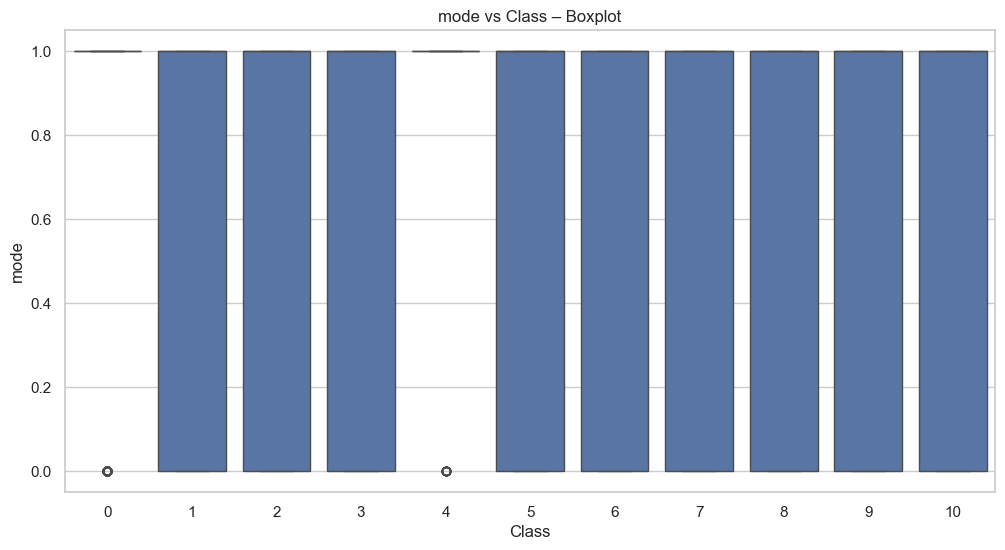

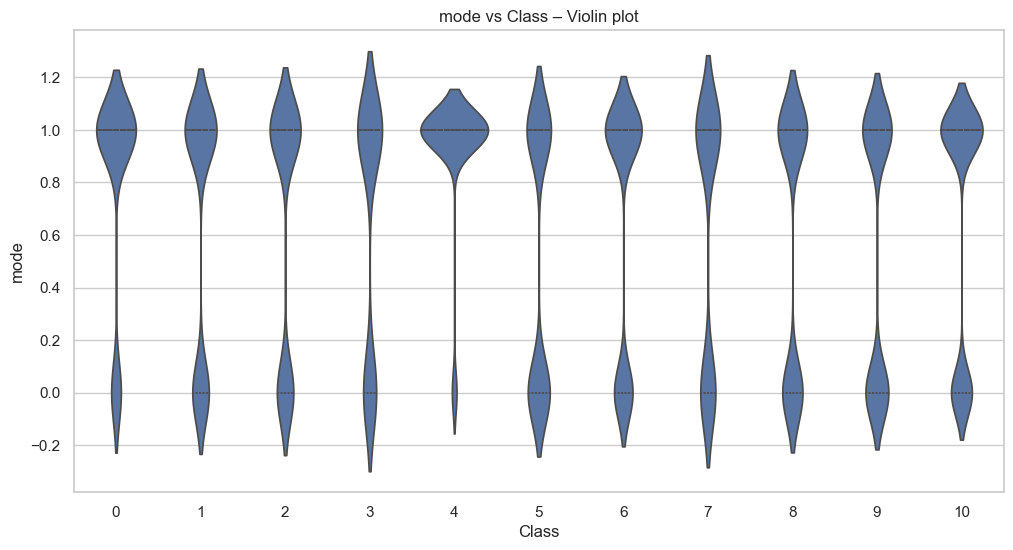

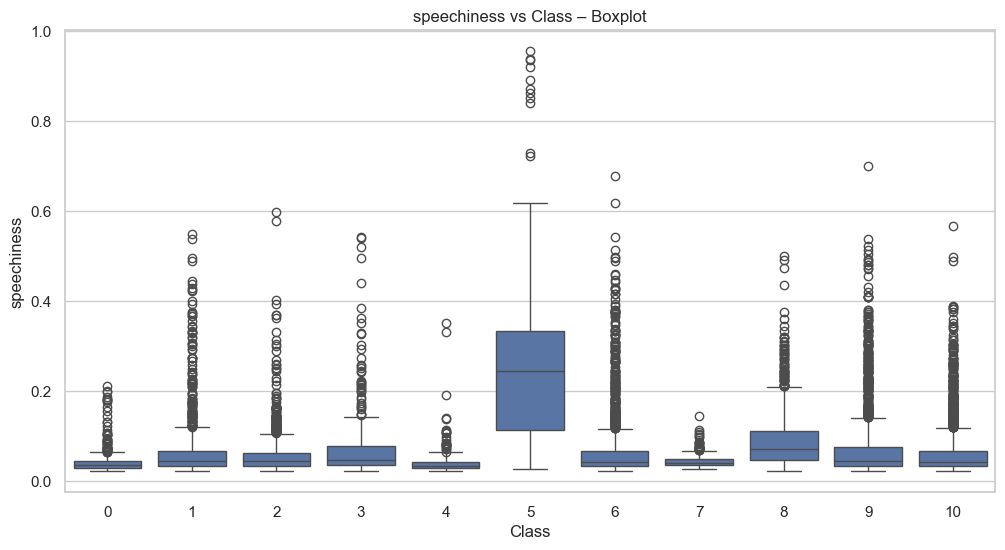

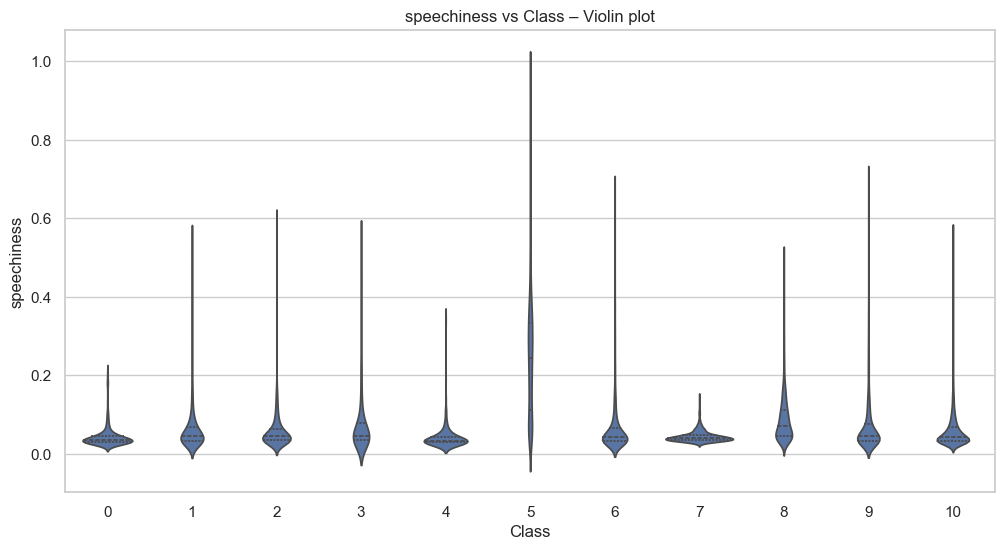

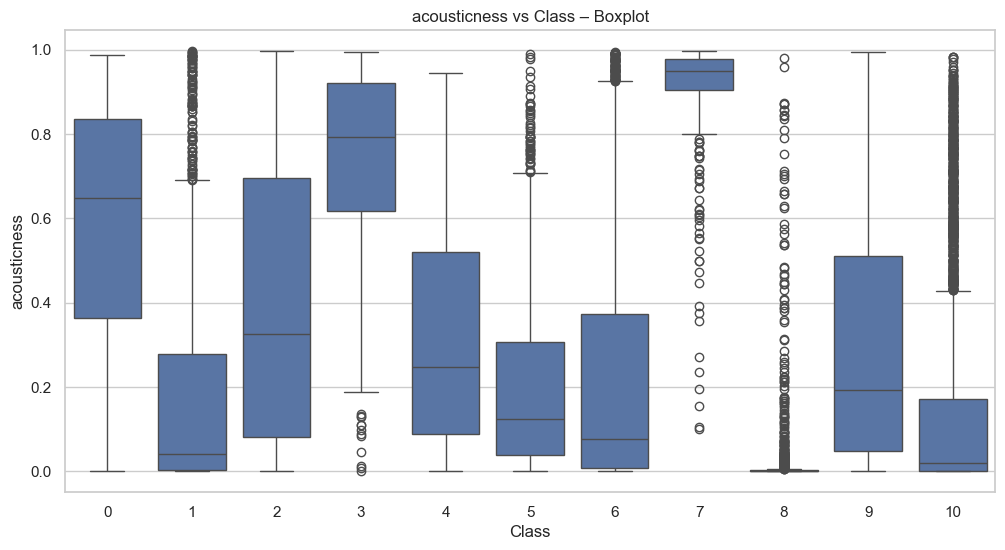

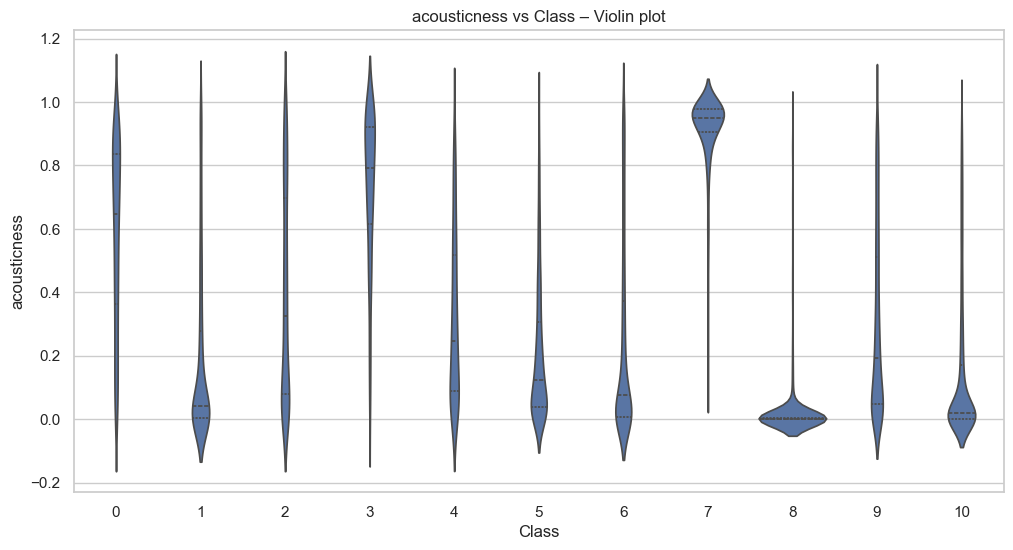

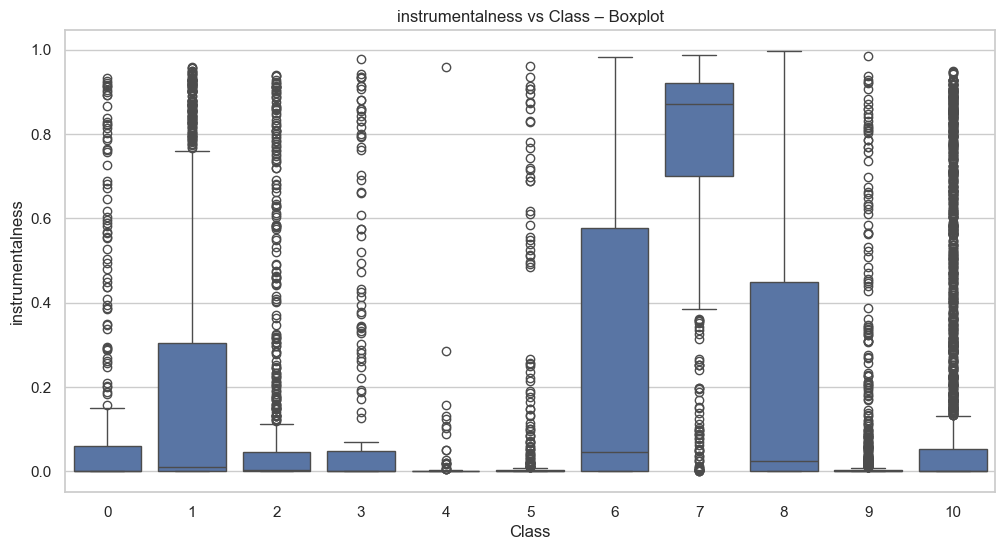

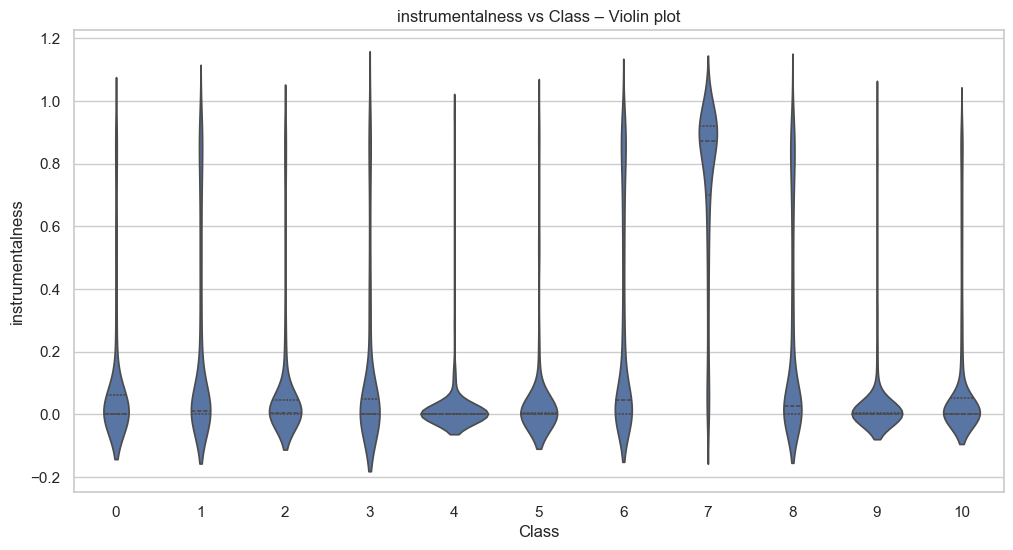

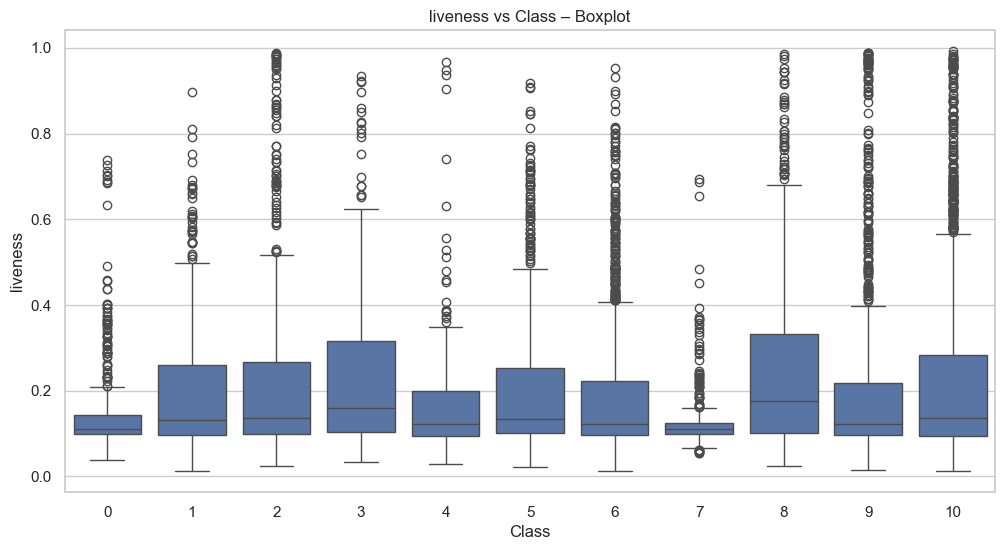

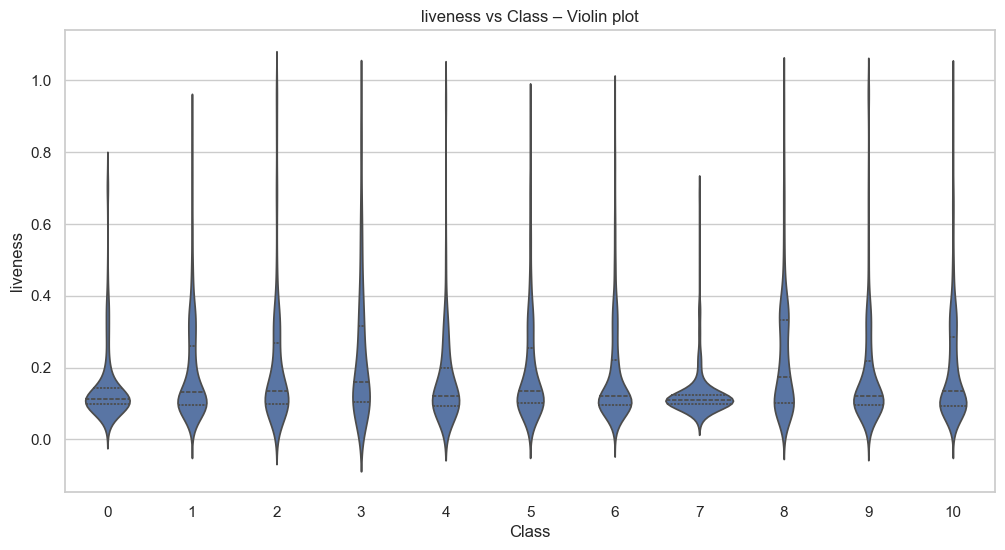

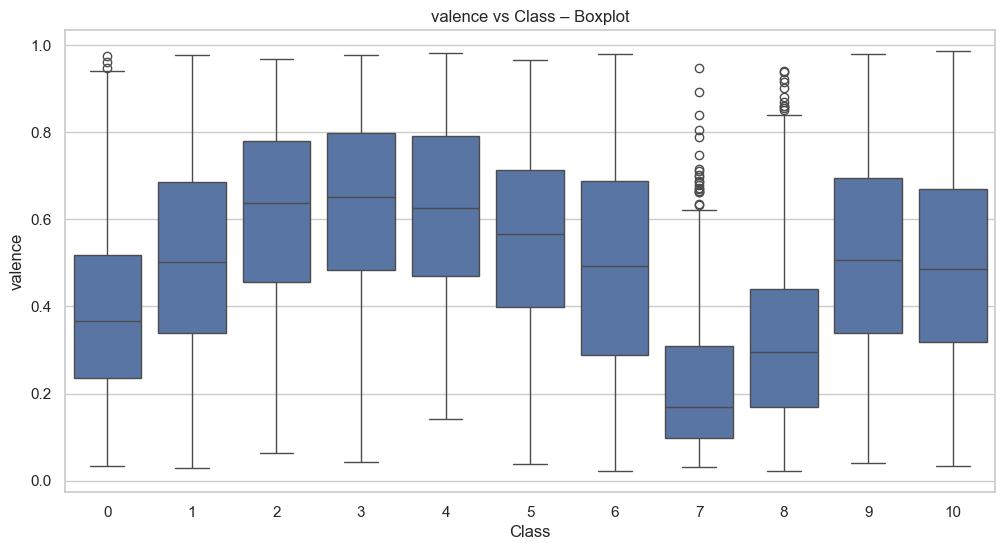

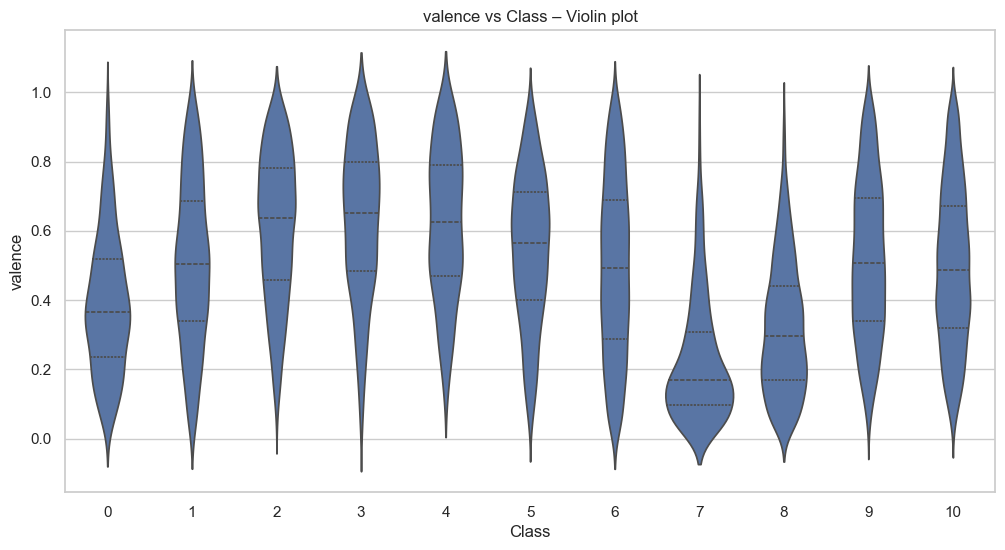

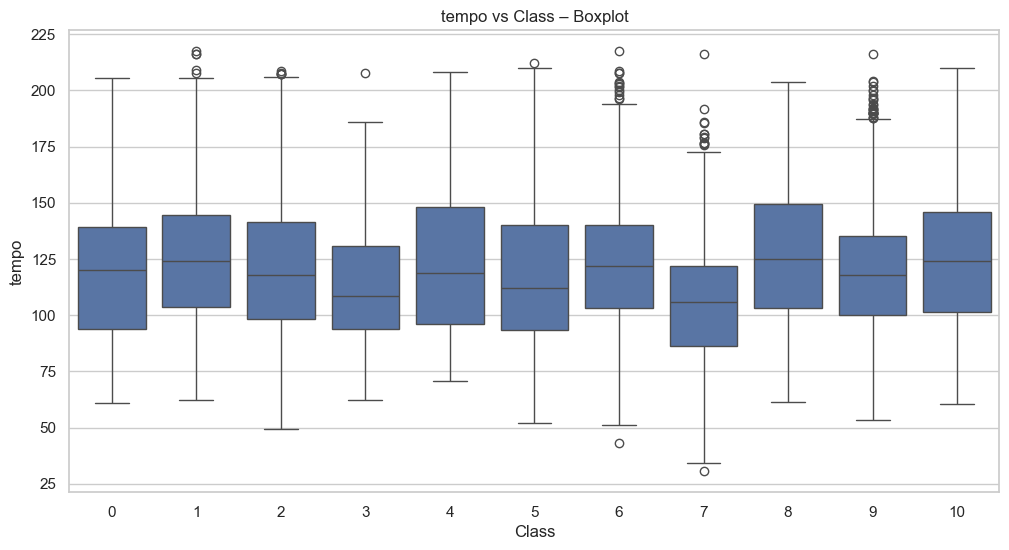

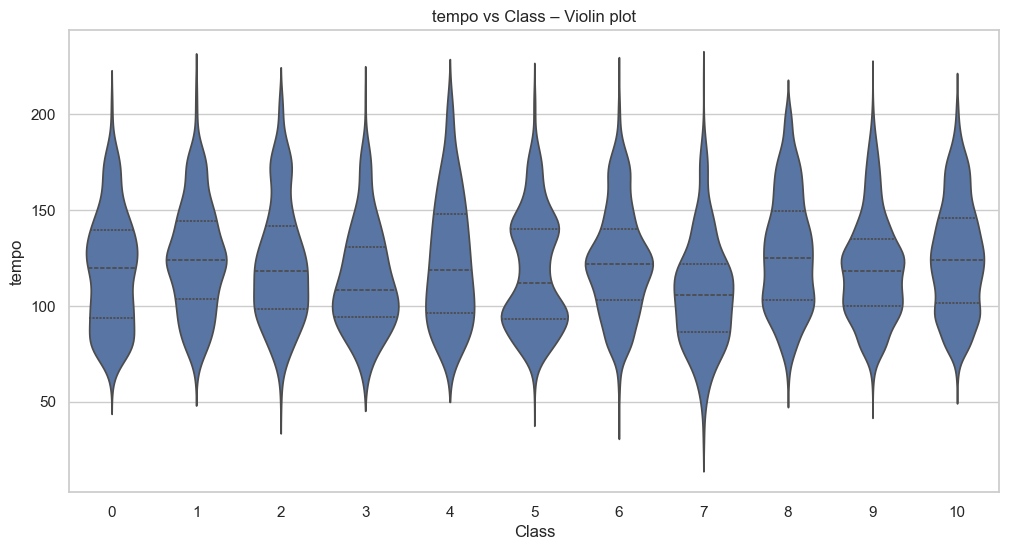

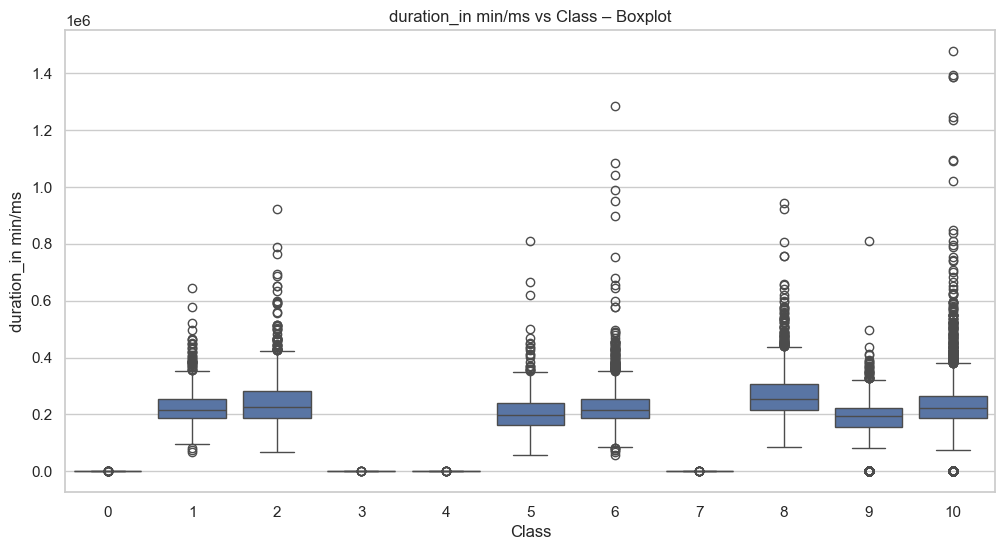

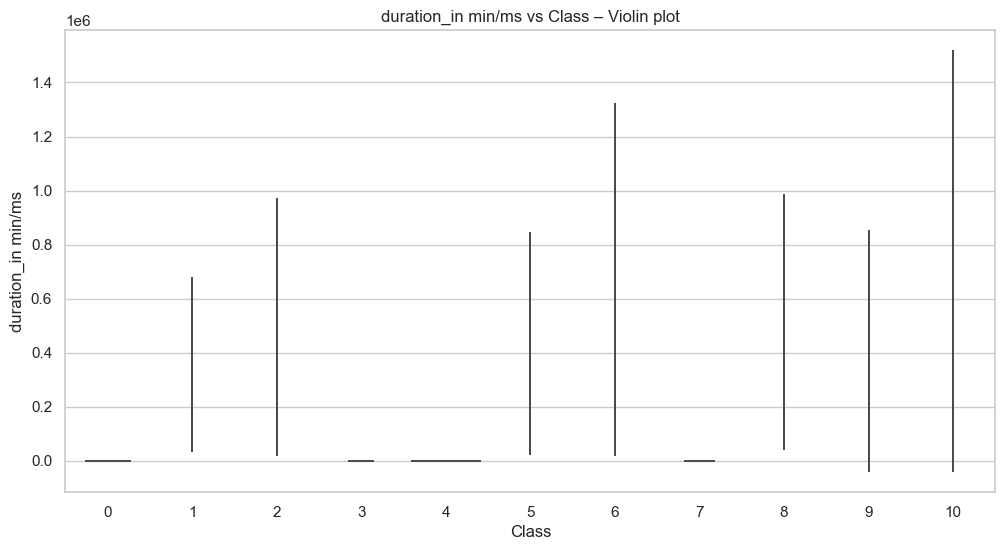

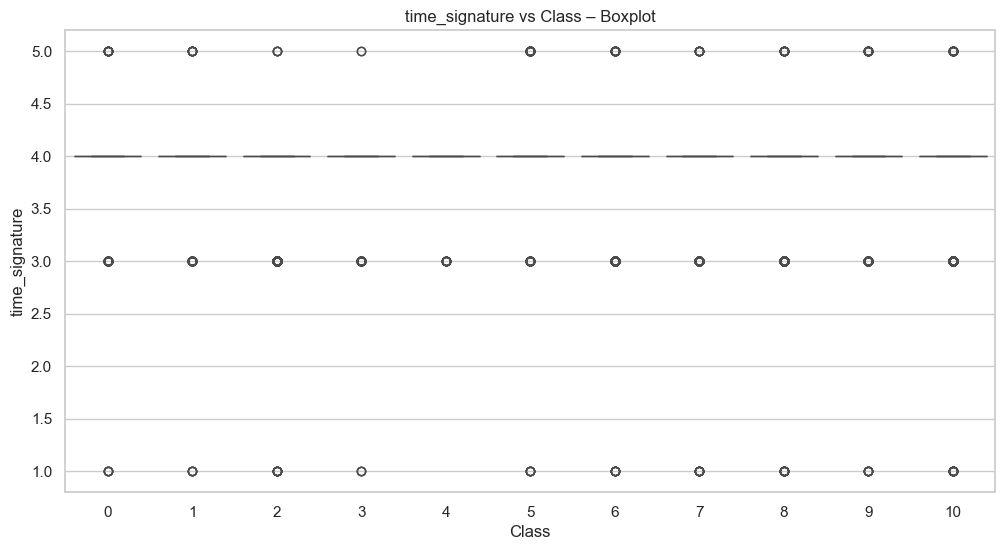

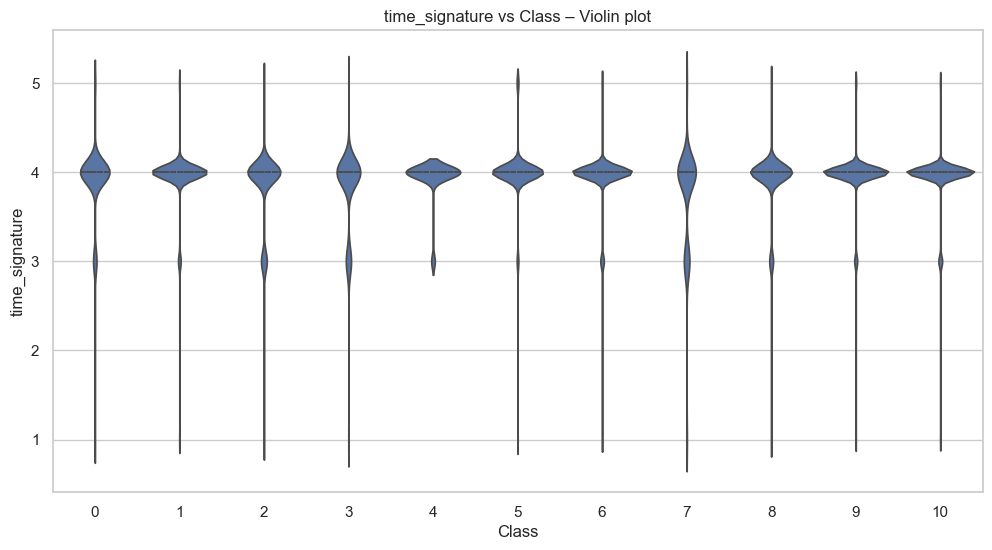

In [8]:
for col in numeric_cols:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=train, x="Class", y=col)
    plt.title(f"{col} vs Class – Boxplot")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.violinplot(data=train, x="Class", y=col, inner="quartile")
    plt.title(f"{col} vs Class – Violin plot")
    plt.show()


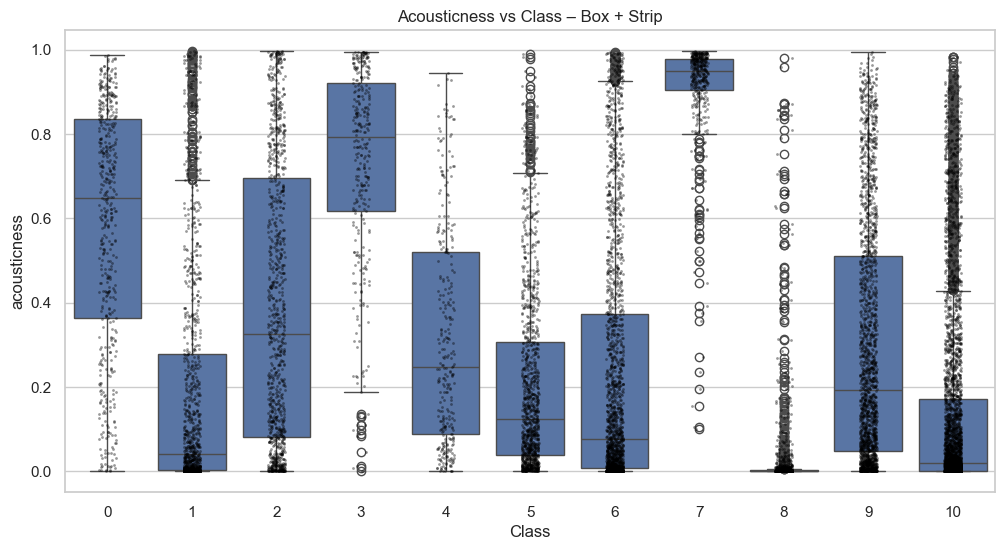

In [9]:
# Ví dụ 1 feature quan trọng: acousticness
plt.figure(figsize=(12, 6))
sns.boxplot(data=train, x="Class", y="acousticness")
sns.stripplot(data=train, x="Class", y="acousticness", color="black", size=2, alpha=0.4)
plt.title("Acousticness vs Class – Box + Strip")
plt.show()


## 7. Kiểm định thống kê: ANOVA & Kruskal-Wallis theo `Class`

Không chỉ nhìn bằng mắt, ta dùng thêm kiểm định thống kê để trả lời:

> "Phân phối của feature X có **khác nhau đáng kể** giữa các lớp `Class` hay không?"

- **ANOVA**: giả định near-normal + phương sai gần tương đương.
- **Kruskal-Wallis**: non-parametric, ít giả định hơn.

Nếu p-value < 0.05:
- Feature đó nhiều khả năng **có phân phối khác giữa các lớp**, tốt cho phân loại.


In [10]:
from scipy.stats import f_oneway, kruskal

anova_results = []

for col in numeric_cols:
    # tách theo class
    groups = [group[col].dropna().values for _, group in train.groupby("Class")]
    
    # ANOVA (giả định gần-normal, var tương đương)
    F, p_anova = f_oneway(*groups)
    
    # Kruskal (non-parametric)
    H, p_kruskal = kruskal(*groups)
    
    anova_results.append({
        "feature": col,
        "F_ANOVA": F,
        "p_ANOVA": p_anova,
        "H_Kruskal": H,
        "p_Kruskal": p_kruskal
    })

anova_df = pd.DataFrame(anova_results)
anova_df["p_ANOVA_sig"] = anova_df["p_ANOVA"] < 0.05
anova_df["p_Kruskal_sig"] = anova_df["p_Kruskal"] < 0.05

display(anova_df.sort_values("p_Kruskal"))


,feature,F_ANOVA,p_ANOVA,H_Kruskal,p_Kruskal,p_ANOVA_sig,p_Kruskal_sig
1,danceability,457.337975,0.000000e+00,3343.680471,0.000000e+00,True,True
2,energy,658.928709,0.000000e+00,4049.752190,0.000000e+00,True,True
6,speechiness,690.551029,0.000000e+00,2739.611454,0.000000e+00,True,True
4,loudness,615.612928,0.000000e+00,2487.974600,0.000000e+00,True,True
7,acousticness,759.493760,0.000000e+00,5259.592815,0.000000e+00,True,True
12,duration_in min/ms,1196.776631,0.000000e+00,4937.285173,0.000000e+00,True,True
10,valence,226.240536,0.000000e+00,1949.439800,0.000000e+00,True,True
8,instrumentalness,301.170952,0.000000e+00,1980.716502,0.000000e+00,True,True
0,Popularity,163.708155,0.000000e+00,1374.371553,3.385527e-289,True,True
13,time_signature,33.142623,2.075152e-64,403.151866,2.008578e-80,True,True


## 8. Tương quan giữa các feature & đa cộng tuyến (Correlation & VIF)

Ở đây ta:

1. Vẽ **ma trận tương quan** để xem:
   - Cặp feature nào đi cùng nhau (corr cao).
   - Feature nào tương quan mạnh (dương/âm) với `Class`.
2. Tính **VIF (Variance Inflation Factor)** để đo lường đa cộng tuyến:
   - VIF > 5 hoặc 10 → feature có thể gây vấn đề với model tuyến tính (Logistic Regression…).

Thông tin này dùng để:
- Quyết định có nên loại bớt feature collinear khi dùng model linear.
- Hiểu cấu trúc không gian feature.


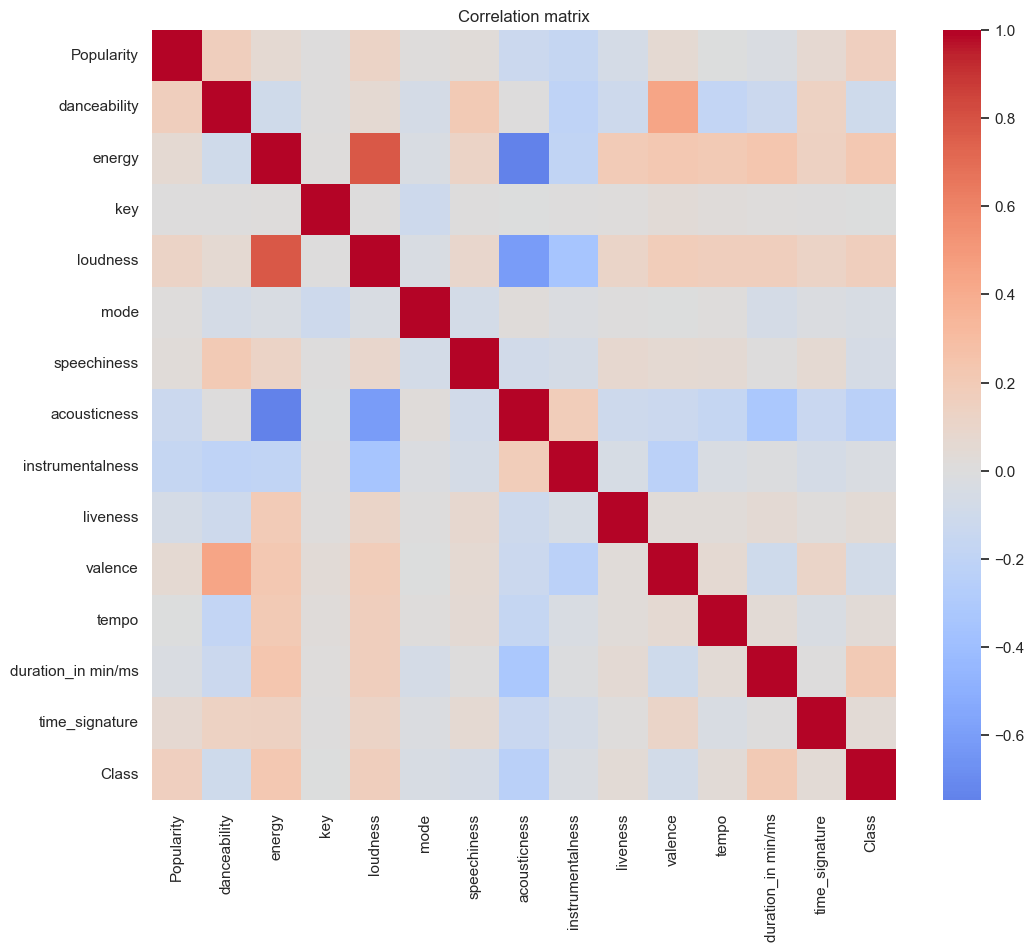

,feature,VIF
13,time_signature,71.651807
2,energy,28.737166
11,tempo,17.762828
1,danceability,17.335320
4,loudness,11.482695
0,Popularity,8.067092
10,valence,7.484730
3,key,4.900802
12,duration_in min/ms,4.713933
7,acousticness,3.543298


In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
corr = train[numeric_cols + ["Class"]].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation matrix")
plt.show()

# Liệt kê cặp tương quan cao
high_corr_pairs = []
for i, f1 in enumerate(numeric_cols):
    for f2 in numeric_cols[i+1:]:
        r = corr.loc[f1, f2]
        if abs(r) > 0.7:
            high_corr_pairs.append((f1, f2, r))

pd.DataFrame(high_corr_pairs, columns=["feat1", "feat2", "corr"]).sort_values("corr", key=abs, ascending=False)

# Tính VIF
X_for_vif = train[numeric_cols].fillna(train[numeric_cols].median())

vif_data = pd.DataFrame()
vif_data["feature"] = X_for_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_for_vif.values, i)
                   for i in range(X_for_vif.shape[1])]

display(vif_data.sort_values("VIF", ascending=False))

## 9. PCA – Giảm chiều và trực quan không gian đặc trưng

PCA giúp:

- Nén thông tin từ nhiều feature về vài thành phần chính (PC1, PC2).
- Trực quan hóa dữ liệu trong 2D xem các lớp `Class` có tách rời tương đối không.

Dù PCA có thể không dùng trực tiếp trong model, nó rất hữu ích để:
- Hiểu cấu trúc tổng thể của dữ liệu.
- Xem mức độ "chồng chéo" giữa các class.


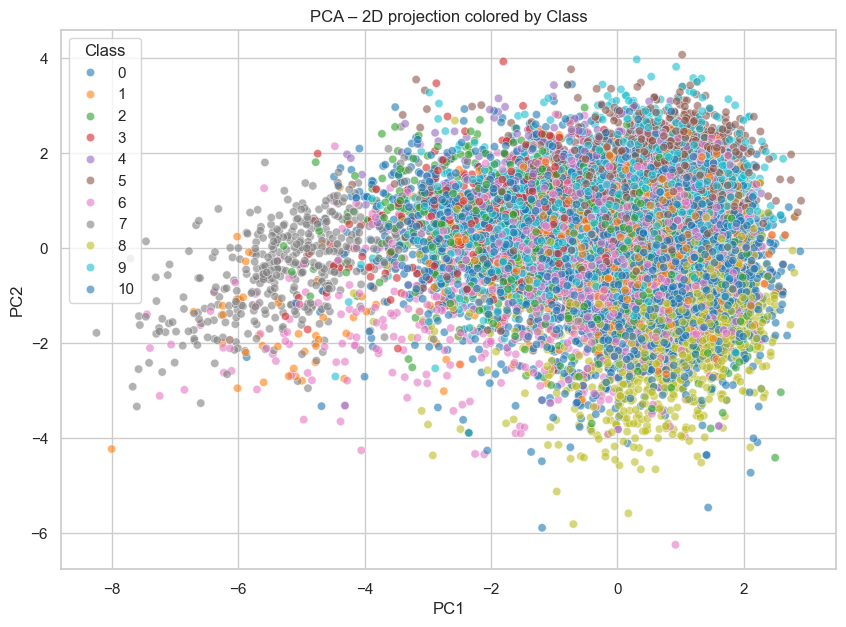

Explained variance ratio: [0.205 0.127]
Total explained: 0.33168994293706044


In [12]:
from sklearn.preprocessing import StandardScaler

X_pca_src = train[numeric_cols].fillna(train[numeric_cols].median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca_src)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "Class": train["Class"].values
})

plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Class", palette="tab10", alpha=0.6)
plt.title("PCA – 2D projection colored by Class")
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_.round(3))
print("Total explained:", pca.explained_variance_ratio_.sum())



## 10. KMeans Clustering & liên hệ với `Class`

Ta dùng KMeans để:

- Chia dữ liệu thành một số cluster (ở đây chọn = số lớp `Class`).
- Sau đó so sánh phân bố `Class` trong từng cluster.

Nếu một cluster gần như chỉ chứa 1–2 class:
- Không gian đặc trưng hiện tại đã encode khá tốt genre.
- Có thể dùng **cluster label** như một feature bổ sung trong Exp2 (tùy cân nhắc).


Class,0,1,2,3,4,5,6,7,8,9,10
cluster,,,,,,,,,,,
0,21,41,16,18,0,0,82,404,4,2,7
1,44,184,243,29,51,80,335,2,50,236,482
2,13,183,47,0,8,21,272,0,489,93,902
3,24,117,15,7,139,128,179,0,48,427,560
4,20,118,163,34,11,162,238,5,19,437,395
5,9,35,66,32,7,35,80,0,85,98,215
6,5,128,46,0,4,41,140,0,409,114,585
7,298,101,221,131,71,31,231,30,19,384,314
8,12,115,46,6,1,11,361,5,306,26,291


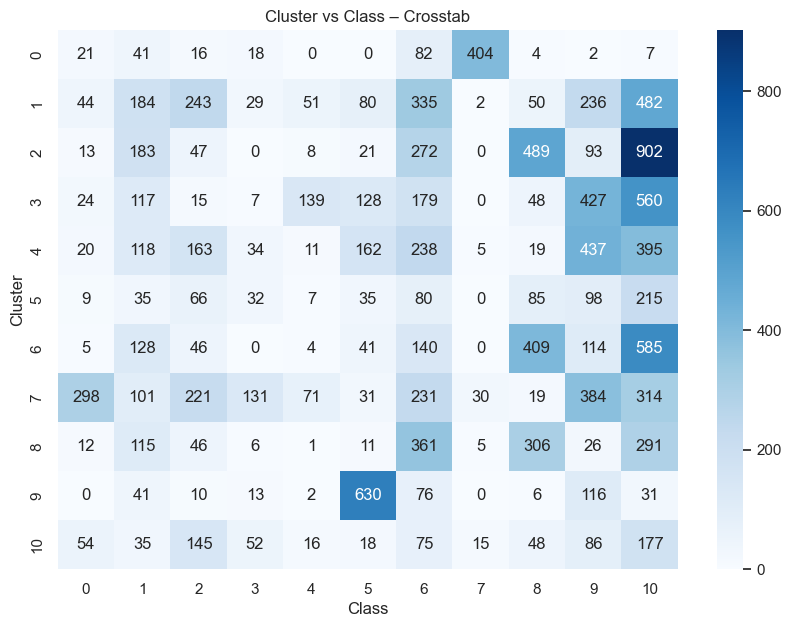

In [13]:
kmeans = KMeans(n_clusters=train["Class"].nunique(), random_state=RANDOM_STATE, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

cluster_df = pd.DataFrame({
    "cluster": clusters,
    "Class": train["Class"].values
})

ct = pd.crosstab(cluster_df["cluster"], cluster_df["Class"])
display(ct)

plt.figure(figsize=(10, 7))
sns.heatmap(ct, annot=True, fmt="d", cmap="Blues")
plt.title("Cluster vs Class – Crosstab")
plt.xlabel("Class")
plt.ylabel("Cluster")
plt.show()


## (Phụ lục) Phân tích theo Artist/Track – phục vụ cho Feature Engineering

Mục tiêu:
- Kiểm tra xem số bài hát mỗi nghệ sĩ có phân bố đều không.
- Kiểm tra xem việc thêm các thống kê theo Artist có ý nghĩa không.
- Phát hiện dữ liệu rò rỉ (leakage) giữa train/test.

Artist Name
Backstreet Boys       58
Westlife              53
Britney Spears        47
Omer Adam             39
Eyal Golan            38
Shlomo Artzi          32
Dudu Aharon           29
Arik Einstein         29
Hadag Nahash          29
Itay Levi             27
Moshe Peretz          27
The Rolling Stones    25
Yehudit Ravitz        23
Dudu Tassa            22
Lata Mangeshkar       22
Metallica             22
AC/DC                 22
U2                    20
Berry Sakharof        20
Shalom Hanoch         19
Name: count, dtype: int64

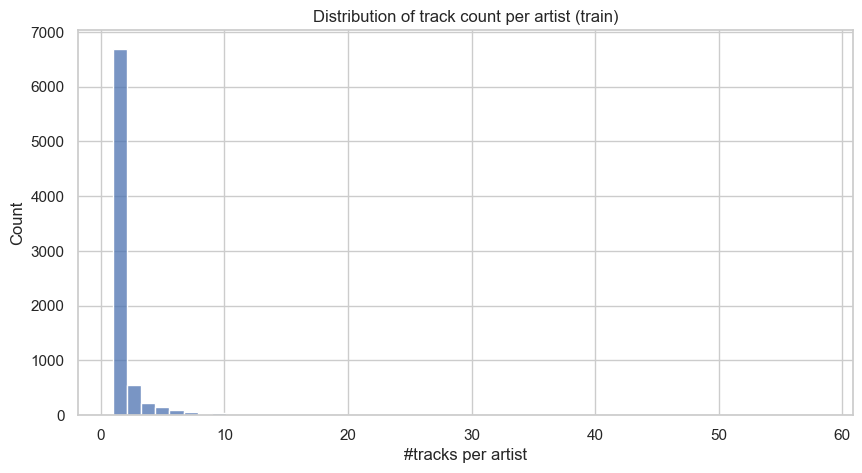

Class distribution of top artist: Backstreet Boys


Class
9    58
Name: count, dtype: int64

Số (Artist, Track) trùng giữa train & test: 590


In [14]:
# Số bài / artist
artist_counts = train["Artist Name"].value_counts()
display(artist_counts.head(20))

plt.figure(figsize=(10, 5))
sns.histplot(artist_counts, bins=50)
plt.title("Distribution of track count per artist (train)")
plt.xlabel("#tracks per artist")
plt.show()

# Class distribution theo một artist lớn
top_artist = artist_counts.index[0]
tmp = train[train["Artist Name"] == top_artist]["Class"].value_counts().sort_index()
print("Class distribution of top artist:", top_artist)
display(tmp)

# Check trùng track giữa train và test (leakage)
train_tracks = set(zip(train["Artist Name"], train["Track Name"]))
test_tracks  = set(zip(test["Artist Name"], test["Track Name"]))
overlap      = train_tracks & test_tracks
print("Số (Artist, Track) trùng giữa train & test:", len(overlap))


## 12. Tổng kết Insight EDA & Liên hệ với Processing/FE

Tóm tắt ngắn gọn:

- **Chất lượng dữ liệu:**
  - Missing tập trung ở `instrumentalness`, `key`, `Popularity` → cần impute (median / mode).
  - Không có quá nhiều outlier “vô lý”, nhưng một số biến như `duration`, `tempo`, `Popularity` khá lệch → cân nhắc log transform.
- **Target `Class`:**
  - Phân phối hơi mất cân bằng (một vài lớp chiếm tỷ trọng cao hơn).
  - Nên dùng Stratified split trong modeling.
- **Feature quan trọng:**
  - `acousticness`, `energy`, `duration`, `loudness`, `Popularity`… cho thấy ảnh hưởng rõ đến `Class` (theo ANOVA, feature importance).
  - `key`, `mode`, `valence`, `danceability` cũng có sự khác biệt nhưng yếu hơn.
- **Quan hệ & cấu trúc:**
  - Một số cặp feature tương quan cao (energy–loudness, v.v.).
  - PCA & clustering cho thấy một số lớp có xu hướng gom lại với nhau.
- **Implication cho Processing:**
  - Thiết kế `impute_missing()`, `add_numeric_fe()` với:
    - log transform (`tempo_log`, `popularity_log`)
    - cyclical encoding (`key_sin`, `key_cos`)
    - interaction (`energy_loudness`)
  - FE theo artist/track: `artist_track_count`, `artist_mean_pop`, `track_count`.

Các insight này sẽ được áp dụng trực tiếp trong notebook **preprocessing** để sinh ra dataset cho **Exp1** và **Exp2**.
